In [ ]:
### Experiment 2: Exploring Different Embedding Models and Retrieval Techniques

In [1]:
!pip install sentence_transformers pandas numpy tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 KB 3.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 68.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 61.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 75.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 45.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 3.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.3/509.3 KB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 75.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 59.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import json
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# Load the dataset
with open(r'combined_all_chunks.json', 'r') as f:
    raw_data = json.load(f)

# Convert to DataFrame for easier handling
if isinstance(raw_data, list):
    dataset = pd.DataFrame(raw_data)
else:
    # If the JSON has a different structure, adjust accordingly
    dataset = pd.DataFrame([raw_data])

# Display the first few rows to understand the structure
print("Dataset shape:", dataset.shape)
print("\nFirst few rows:")
dataset.head()

# Extract and structure metadata
if isinstance(raw_data,list):
    dataset=pd.DataFrame(raw_data)
else:
    dataset=pd.DataFrame([raw_data])
dataset['metadata'] = dataset['metadata'].apply(json.loads)

dataset['code_snippet'] = dataset['metadata'].apply(lambda x: x.get('code_snippet', ''))
dataset['length'] = dataset['metadata'].apply(lambda x: x.get('length', None))
dataset['filename'] = dataset['metadata'].apply(lambda x: x.get('filename', ''))
dataset['previous_chunk_id'] = dataset['metadata'].apply(lambda x: x.get('previous_chunk_id', None))
dataset['next_chunk_id'] = dataset['metadata'].apply(lambda x: x.get('next_chunk_id', None))

final_dataset = dataset[['chunk_id', 'doc', 'title', 'code_snippet', 'length', 'filename']]
final_dataset.columns

final_dataset.head()


In [3]:
#final_dataset.to_csv('/home/user/Desktop/embedding_openai_bm25/output_chunk_file_reports.csv', index=False, encoding='utf-8')

In [4]:
from sentence_transformers import SentenceTransformer
import time

def measure_embedding_time(embed_function, texts):
    start_time = time.time()
    embeddings = embed_function(texts)
    end_time = time.time()
    return embeddings, end_time - start_time

# Extract text from the dataset
texts = final_dataset["doc"].tolist()[:100]  # Limiting to 100 samples for demonstration


In [5]:
# ### 2.1 E5-large-v2 (1024 dimensions)

print("Loading E5-large-v2 model...")
e5_model = SentenceTransformer('intfloat/e5-large-v2', device='cpu')

# Generate embeddings with CPU only
print("Generating E5-large-v2 embeddings...")
e5_embeddings, e5_time = measure_embedding_time(
    lambda x: e5_model.encode(x, batch_size=4, normalize_embeddings=True, device='cpu'),
    texts
)

print(f"E5-large-v2 embeddings generated in {e5_time:.2f} seconds")
print(f"Embedding dimension: {e5_embeddings.shape[1]}")
print(f"Number of embeddings: {len(e5_embeddings)}")


Loading E5-large-v2 model...
Generating E5-large-v2 embeddings...
E5-large-v2 embeddings generated in 22.68 seconds
Embedding dimension: 1024
Number of embeddings: 100


In [6]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in e5_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in e5_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")



Total parameters: 335,141,888
Estimated model size: 1278.46 MB


In [7]:
# ### 2.2 GTE-Large (1024 dimensions)

# Load the GTE-Large model which has 1024 dimensions
print("Loading GTE-Large model...")
gte_model = SentenceTransformer('thenlper/gte-large', device='cpu')

# Generate embeddings with CPU only
print("Generating GTE-Large embeddings...")
gte_embeddings, gte_time = measure_embedding_time(
    lambda x: gte_model.encode(x, batch_size=4, normalize_embeddings=True, device='cpu'),
    texts
)
print(f"GTE-Large embeddings generated in {gte_time:.2f} seconds")
print(f"Embedding dimension: {gte_embeddings.shape[1]}")
print(f"Number of embeddings: {len(gte_embeddings)}")


Loading GTE-Large model...
Generating GTE-Large embeddings...
GTE-Large embeddings generated in 22.41 seconds
Embedding dimension: 1024
Number of embeddings: 100


In [8]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in gte_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in gte_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")


Total parameters: 335,141,888
Estimated model size: 1278.46 MB


In [9]:
# ### 2.3 BGE Large v1.5 (1024 dimensions)

print("Loading BGE Large v1.5 model...")
bge_model = SentenceTransformer('BAAI/bge-large-en-v1.5', device='cpu')

# Generate embeddings with CPU only
print("Generating BGE embeddings...")
bge_embeddings, bge_time = measure_embedding_time(
    lambda x: bge_model.encode(x, batch_size=4, normalize_embeddings=True, device='cpu'),
    texts
)
print(f"BGE embeddings generated in {bge_time:.2f} seconds")
print(f"Embedding dimension: {bge_embeddings.shape[1]}")
print(f"Number of embeddings: {len(bge_embeddings)}")

Loading BGE Large v1.5 model...
Generating BGE embeddings...
BGE embeddings generated in 22.24 seconds
Embedding dimension: 1024
Number of embeddings: 100


In [10]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in bge_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in bge_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")

Total parameters: 335,141,888
Estimated model size: 1278.46 MB


In [11]:
# ### 2.5 Instructor XL (1536 dimensions)

print("Loading Iinfly model...")
inf_model = SentenceTransformer('infly/inf-retriever-v1', device='cpu')

# Generate embeddings with CPU only - using code-specific instruction
print("Generating infly embeddings...")
inf_embeddings, inf_time = measure_embedding_time(
    lambda x: inf_model.encode(
        [["Represent code for retrieval: ", text] for text in x], 
        batch_size=4, 
        normalize_embeddings=True, 
        device='cpu'
    ),
    texts
)
print(f"inf_model embeddings generated in {inf_time:.2f} seconds")
print(f"Embedding dimension: {inf_embeddings.shape[1]}")
print(f"Number of embeddings: {len(inf_embeddings)}")


Loading Iinfly model...


Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


Generating infly embeddings...
inf_model embeddings generated in 360.13 seconds
Embedding dimension: 3584
Number of embeddings: 100


In [12]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in inf_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in inf_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")

Total parameters: 7,069,121,024
Estimated model size: 26966.56 MB


In [13]:
print("BAAI/bge-m3 model...")
bge_m3_model = SentenceTransformer('BAAI/bge-m3', device='cpu')

# Generate embeddings with CPU only - using code-specific instruction
print("Generating BAAI/bge-m3 embeddings...")
bge_m3_embeddings, bge_m3_time = measure_embedding_time(
    lambda x: bge_m3_model.encode(
        [["Represent code for retrieval: ", text] for text in x], 
        batch_size=4, 
        normalize_embeddings=True, 
        device='cpu'
    ),
    texts
)
print(f"BAAI/bge-m3 embeddings generated in {bge_m3_time:.2f} seconds")
print(f"Embedding dimension: {bge_m3_embeddings.shape[1]}")
print(f"Number of embeddings: {len(bge_m3_embeddings)}")

BAAI/bge-m3 model...
Generating BAAI/bge-m3 embeddings...
BAAI/bge-m3 embeddings generated in 31.45 seconds
Embedding dimension: 1024
Number of embeddings: 100


In [14]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in bge_m3_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in bge_m3_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")

Total parameters: 567,754,752
Estimated model size: 2165.81 MB


In [15]:
!pip install "generative-ai-hub-sdk[all]"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.6/613.6 KB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.4/720.4 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.7/431.7 KB 9.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.7/153.7 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.4/95.4 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 43.5 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.3/109.3 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.5 MB/s eta 0:00:00
  

In [16]:
# ### 2.6 OpenAI Embeddings (1536 dimensions)

import os
import asyncio
import nest_asyncio
from dotenv import load_dotenv
from tqdm import tqdm
import time
import requests
from gen_ai_hub.proxy.native.openai import AsyncOpenAI

# Apply nest_asyncio for notebook environments
nest_asyncio.apply()

# Load environment variables
load_dotenv('chunk.env')

# Define global variable for timing
openai_time = 0

# Get authentication token
def get_auth_token():
    auth_url = os.getenv('AICORE_AUTH_URL')
    client_id = os.getenv('AICORE_CLIENT_ID')
    client_secret = os.getenv('AICORE_CLIENT_SECRET')
    
    response = requests.post(
        auth_url,
        data={
            'grant_type': 'client_credentials',
            'client_id': client_id,
            'client_secret': client_secret
        },
        headers={'Content-Type': 'application/x-www-form-urlencoded'}
    )
    
    if response.status_code == 200:
        token_data = response.json()
        return token_data.get('access_token')
    else:
        raise Exception(f"Auth failed: {response.status_code} - {response.text}")

# Client cache to avoid recreating clients
client_cache = {}

# Function to get or create client for a model instance
def get_client(model_instance):
    if model_instance in client_cache:
        return client_cache[model_instance]
    
    # Get deployment ID for this instance
    deployment_id = os.getenv(f'AICORE_DEPLOYMENT_ID_{model_instance}')
    if not deployment_id:
        raise ValueError(f"No deployment ID found for {model_instance}")
    
    # Get auth token
    token = get_auth_token()
    
    # Create client
    client = AsyncOpenAI(
        base_url=os.getenv('AICORE_BASE_URL'),
        api_key="dummy",  # Not used with SAP AI Core
        default_headers={
            "Authorization": f"Bearer {token}",
            "AI-Resource-Group": os.getenv('AICORE_RESOURCE_GROUP', 'default'),
            "AI-Deployment-ID": deployment_id
        }
    )
    
    # Cache the client
    client_cache[model_instance] = client
    return client

# Function to generate embeddings with specific model instance
async def get_embedding(text, model_instance="embed_1", model="text-embedding-ada-002"):
    if not isinstance(text, str):
        raise ValueError("Expected text to be a string")
    
    text = text.replace("\n", " ")
    
    # Get client for this model instance
    client = get_client(model_instance)
    
    response = await client.embeddings.create(
        input=text,
        model=model
    )
    return response.data[0].embedding

# OpenAI Embedding Wrapper Class
class OpenAIEmbeddingWrapper:
    def __init__(self, model_instances=None, model="text-embedding-ada-002"):
        if model_instances is None:
            model_instances = ["embed_1", "embed_2", "embed_3"]
        self.model_instances = model_instances
        self.model = model

    async def _get_embedding_async(self, text, model_instance):
        try:
            # Ensure text is a string and remove newlines
            if not isinstance(text, str):
                raise ValueError("Expected text to be a string")
            text = text.replace("\n", " ")
            
            # Get client for this model instance
            client = get_client(model_instance)
            
            response = await client.embeddings.create(
                input=text,
                model=self.model
            )
            return response.data[0].embedding
        except Exception as e:
            print(f"Error with {model_instance}: {e}")
            for next_instance in self.model_instances:
                if next_instance != model_instance:
                    try:
                        print(f"Retrying with {next_instance}")
                        embedding = await self._get_embedding_async(text, next_instance)
                        return embedding
                    except Exception as e2:
                        print(f"Error on retry: {e2}")
            return None

    def encode(self, texts):
        """
        Encode texts to embeddings.
        
        Args:
            texts: A string or list of strings to encode
            
        Returns:
            A list of embeddings (one per text)
        """
        # Ensure texts is always a list
        if isinstance(texts, str):
            texts = [texts]
        
        embeddings = []
        loop = asyncio.get_event_loop()

        # Use tqdm for progress tracking
        from tqdm import tqdm
        
        for i, text in enumerate(tqdm(texts, desc="Generating OpenAI embeddings")):
            try:
                # Rotate through model instances for load balancing
                model_instance = self.model_instances[i % len(self.model_instances)]
                embedding = loop.run_until_complete(self._get_embedding_async(text, model_instance))
                embeddings.append(embedding)
            except Exception as e:
                print(f"Error in encode for text {i}: {e}")
                embeddings.append(None)

        return embeddings

# Process texts with rotating model instances for load balancing
async def process_texts_with_rotation(texts):
    global openai_time
    openai_embeddings = []
    start_time = time.time()
    
    # Available model instances
    instances = ["embed_1", "embed_2", "embed_3"]
    
    for i, text in enumerate(tqdm(texts)):
        # Rotate through model instances
        model_instance = instances[i % len(instances)]
        try:
            embedding = await get_embedding(text, model_instance=model_instance)
            openai_embeddings.append(embedding)
        except Exception as e:
            print(f"Error with {model_instance}: {e}")
            # Try next instance if one fails
            try:
                next_instance = instances[(i + 1) % len(instances)]
                print(f"Retrying with {next_instance}")
                embedding = await get_embedding(text, model_instance=next_instance)
                openai_embeddings.append(embedding)
            except Exception as e2:
                print(f"Error on retry: {e2}")
                openai_embeddings.append(None)
    
    openai_time = time.time() - start_time
    print(f"Embeddings generated in {openai_time:.2f} seconds")
    
    if openai_embeddings and openai_embeddings[0]:
        print(f"Embedding dimension: {len(openai_embeddings[0])}")
    print(f"Number of embeddings: {len(openai_embeddings)}")
    
    return openai_embeddings

# Initialize OpenAI wrapper
openai_model = OpenAIEmbeddingWrapper()

# Generate OpenAI embeddings
print("Generating embeddings via gen_ai_hub with rotation...")
openai_embeddings = asyncio.run(process_texts_with_rotation(texts))


Generating embeddings via gen_ai_hub with rotation...


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]

Embeddings generated in 36.68 seconds
Embedding dimension: 1536
Number of embeddings: 100


In [17]:
!pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from huggingface_hub import login
import os

def login_to_huggingface():

    # Method 1: Using environment variable
    # You can set the HF_TOKEN environment variable
    os.environ["HF_TOKEN"] = ""
    
    # Method 2: Interactive login (recommended for security)
    # This will prompt you to enter your token
    #token = input("Enter your Hugging Face token: ")
    #login(token=token)
    #print("Successfully logged in to Hugging Face!")
    
    # Method 3: Using the token directly (not recommended for shared code)
    # login(token="your_huggingface_token")

if __name__ == "__main__":
    login_to_huggingface()

In [19]:
# Load the Code Llama embedding model
print("Loading Codellama embedding model...")
codellama_model = SentenceTransformer('meta-llama/CodeLlama-7b-hf', device='cpu')

# Set the padding token to be the same as the EOS token
if codellama_model.tokenizer.pad_token is None:
    codellama_model.tokenizer.pad_token = codellama_model.tokenizer.eos_token
    
# Generate embeddings with CPU only
print("Generating starcoder embeddings...")
codellama_embeddings, codellama_time = measure_embedding_time(
    lambda x: codellama_model.encode(x, batch_size=2, normalize_embeddings=True, device='cpu'),
    texts
)
print(f"starcoder embeddings generated in {codellama_time:.2f} seconds")
print(f"Embedding dimension: {codellama_embeddings.shape[1]}")
print(f"Number of embeddings: {len(codellama_embeddings)}")

Loading Codellama embedding model...


No sentence-transformers model found with name meta-llama/CodeLlama-7b-hf. Creating a new one with mean pooling.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]


Generating starcoder embeddings...
starcoder embeddings generated in 413.89 seconds
Embedding dimension: 4096
Number of embeddings: 100


In [20]:
# 1. Total number of parameters
total_params = sum(p.numel() for p in codellama_model.parameters())
print(f"Total parameters: {total_params:,}")

# 2. Model size in memory
model_size_bytes = sum(p.numel() * p.element_size() for p in codellama_model.parameters())
model_size_mb = model_size_bytes / (1024 ** 2)
print(f"Estimated model size: {model_size_mb:.2f} MB")




Total parameters: 6,607,409,152
Estimated model size: 25205.27 MB


In [21]:
!pip install fastembed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 KB 461.9 kB/s eta 0:00:00 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 KB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 66.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 KB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 11.8 MB/s eta 0:00:00


In [22]:
# ### 2.8 Sparse Embeddings with BM25 (complementary to dense embeddings)

from fastembed import SparseTextEmbedding

print("Loading BM25 model...")
bm25_embedding_model = SparseTextEmbedding("Qdrant/bm25")

# Generate sparse embeddings
print("Generating BM25 sparse embeddings...")
start_time = time.time()
bm25_embeddings = list(bm25_embedding_model.passage_embed(texts))
bm25_time = time.time() - start_time

print(f"BM25 embeddings generated in {bm25_time:.2f} seconds")
print(f"Number of BM25 embeddings: {len(bm25_embeddings)}")
print(f"Example BM25 embedding: {bm25_embeddings[0].as_dict()}")

Loading BM25 model...


Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 45.16it/s]


Generating BM25 sparse embeddings...
BM25 embeddings generated in 0.03 seconds
Number of BM25 embeddings: 100
Example BM25 embedding: {418310737: 1.5738437892971915, 144051554: 2.0378478127148387, 1458396614: 1.5738437892971915, 1167338989: 1.2251468348923211, 933802348: 1.8349759713285005, 1399361890: 2.0378478127148387, 641650763: 1.738808274158691, 2041386363: 1.8349759713285005, 358389376: 1.2251468348923211, 989116115: 1.2251468348923211, 1262366007: 1.2251468348923211, 546776626: 1.2251468348923211, 332135977: 1.5738437892971915, 1430125705: 1.2251468348923211, 1289414591: 1.2251468348923211, 1285987188: 1.2251468348923211, 609270800: 1.2251468348923211, 640494850: 1.2251468348923211, 889991415: 1.2251468348923211, 569047032: 1.5738437892971915, 1956269320: 1.2251468348923211, 46395304: 1.5738437892971915, 2045916435: 1.2251468348923211, 870749883: 1.2251468348923211, 563226112: 1.5738437892971915, 958659146: 1.2251468348923211, 1863550060: 1.2251468348923211, 1141099794: 1.22514

In [23]:
# ### 2.9 Late Interaction Embeddings with ColBERT (complementary approach)

from fastembed import LateInteractionTextEmbedding

print("Loading ColBERT model...")
late_interaction_embedding_model = LateInteractionTextEmbedding("colbert-ir/colbertv2.0")

# Generate late interaction embeddings
print("Generating ColBERT late interaction embeddings...")
start_time = time.time()
late_interaction_embeddings = list(late_interaction_embedding_model.passage_embed(texts))
late_interaction_time = time.time() - start_time

print(f"ColBERT embeddings generated in {late_interaction_time:.2f} seconds")
print(f"Number of ColBERT embeddings: {len(late_interaction_embeddings)}")
print(f"Dimensions of first ColBERT embedding: {len(late_interaction_embeddings[0])} tokens with {len(late_interaction_embeddings[0][0])} dimensions each")


Loading ColBERT model...


Fetching 5 files: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


Generating ColBERT late interaction embeddings...
ColBERT embeddings generated in 10.01 seconds
Number of ColBERT embeddings: 100
Dimensions of first ColBERT embedding: 512 tokens with 128 dimensions each


In [24]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 17.7 MB/s eta 0:00:00


In [25]:
# ## 3. Compare All High-Dimensional Embedding Models

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a comparison dataframe
comparison = pd.DataFrame({
    'Model': [
        'E5-large-v2', 
        'GTE-Large', 
        'BGE-Large-v1.5',
        'inf-retriever-v1',
        'BAAI/bge-m3',
        'OpenAI-text-embedding-ada-002', 
        'Codellama',
        'BM25 (Sparse)', 
        'ColBERT (Late Interaction)'
    ],
    'Type': [
        'Dense', 'Dense', 'Dense', 'Dense', 'Dense', 'Dense', 'Dense', 'Sparse', 'Late Interaction'
    ],
    'Is Code-Specific': [
        'No', 'No', 'No', 'Instruction-tuned', 'No', 'No', 'Yes', 'No', 'No'
    ],
    'Generation Time (s)': [
        e5_time, 
        gte_time, 
        bge_time,
        inf_time,
        bge_m3_time,
        openai_time,
        codellama_time,
        bm25_time,
        late_interaction_time
    ],
    'Samples': [
        len(e5_embeddings) if isinstance(e5_embeddings, np.ndarray) else 0,
        len(gte_embeddings) if isinstance(gte_embeddings, np.ndarray) else 0,
        len(bge_embeddings) if isinstance(bge_embeddings, np.ndarray) else 0,
        len(inf_embeddings) if isinstance(inf_embeddings, np.ndarray) else 0,
        len(bge_m3_embeddings) if isinstance(bge_m3_embeddings, np.ndarray) else 0,
        len(openai_embeddings) if openai_embeddings else 0,
        len(codellama_embeddings) if isinstance(codellama_embeddings, np.ndarray) else 0,
        len(bm25_embeddings) if isinstance(bm25_embeddings, list) else 0,
        len(late_interaction_embeddings) if isinstance(late_interaction_embeddings, list) else 0
    ]
})


In [26]:
# Add dimension information
comparison['Dimension'] = [
    e5_embeddings.shape[1] if isinstance(e5_embeddings, np.ndarray) else 0,
    gte_embeddings.shape[1] if isinstance(gte_embeddings, np.ndarray) else 0,
    bge_embeddings.shape[1] if isinstance(bge_embeddings, np.ndarray) else 0,
    inf_embeddings.shape[1] if isinstance(inf_embeddings, np.ndarray) else 0,
    bge_m3_embeddings.shape[1] if isinstance(bge_m3_embeddings, np.ndarray) else 0,
    len(openai_embeddings[0]) if openai_embeddings and openai_embeddings[0] else 0,
    codellama_embeddings.shape[1] if isinstance(codellama_embeddings, np.ndarray) else 0,
    "Variable (Sparse)",
    f"{len(late_interaction_embeddings[0])} tokens × {len(late_interaction_embeddings[0][0])} dims" if isinstance(late_interaction_embeddings, list) and len(late_interaction_embeddings) > 0 else 0
]

# Add normalized time metric for dense embeddings
comparison['Time per Dimension (ms)'] = None  # Initialize column with None instead of NaN
for i in range(7):  # Only calculate for dense embeddings
    if isinstance(comparison.loc[i, 'Dimension'], (int, float)) and comparison.loc[i, 'Dimension'] > 0:
        comparison.loc[i, 'Time per Dimension (ms)'] = (comparison.loc[i, 'Generation Time (s)'] * 1000) / comparison.loc[i, 'Dimension']

# Add note for special embedding types
comparison.loc[7, 'Time per Dimension (ms)'] = "N/A for sparse embeddings"
comparison.loc[8, 'Time per Dimension (ms)'] = "N/A for late interaction"

# Display the comparison
print("Model Comparison:")
print(comparison)

Model Comparison:
                           Model              Type   Is Code-Specific  \
0                    E5-large-v2             Dense                 No   
1                      GTE-Large             Dense                 No   
2                 BGE-Large-v1.5             Dense                 No   
3               inf-retriever-v1             Dense  Instruction-tuned   
4                    BAAI/bge-m3             Dense                 No   
5  OpenAI-text-embedding-ada-002             Dense                 No   
6                      Codellama             Dense                Yes   
7                  BM25 (Sparse)            Sparse                 No   
8     ColBERT (Late Interaction)  Late Interaction                 No   

   Generation Time (s)  Samples              Dimension  \
0            22.682709      100                   1024   
1            22.405375      100                   1024   
2            22.244879      100                   1024   
3           360.134

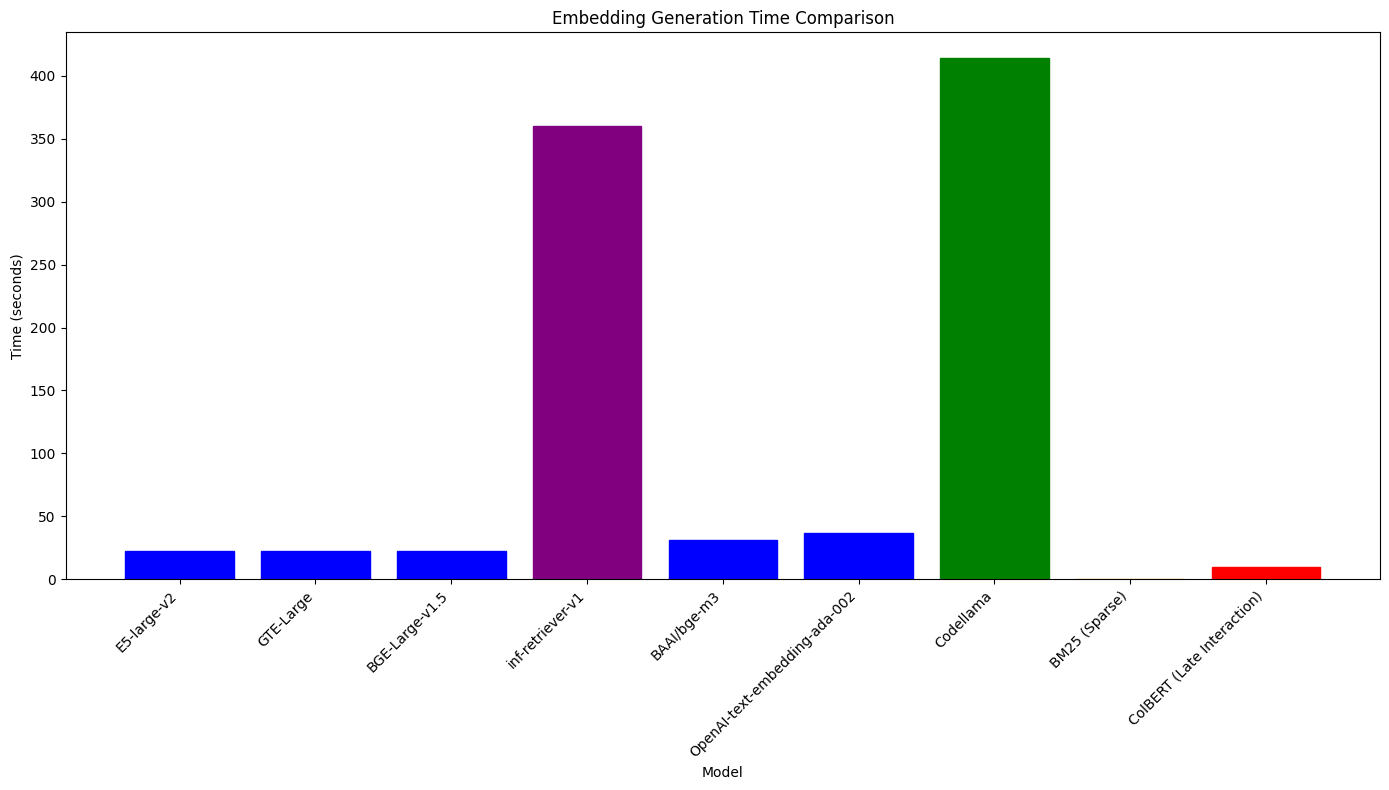

In [27]:
# Plot generation time comparison
plt.figure(figsize=(14, 8))
bars = plt.bar(comparison['Model'], comparison['Generation Time (s)'])

# Define colors by type and code-specificity
colors_map = {
    ('Dense', 'No'): 'blue',
    ('Dense', 'Yes'): 'green',
    ('Dense', 'Instruction-tuned'): 'purple',
    ('Sparse', 'No'): 'orange',
    ('Late Interaction', 'No'): 'red'
}

# Color bars by embedding type and code-specificity
for i, bar in enumerate(bars):
    model_type = comparison.iloc[i]['Type']
    is_code_specific = comparison.iloc[i]['Is Code-Specific']
    bar.set_color(colors_map.get((model_type, is_code_specific), 'gray'))

plt.title('Embedding Generation Time Comparison')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('embedding_time_comparison.png')  # Save the figure
plt.show()


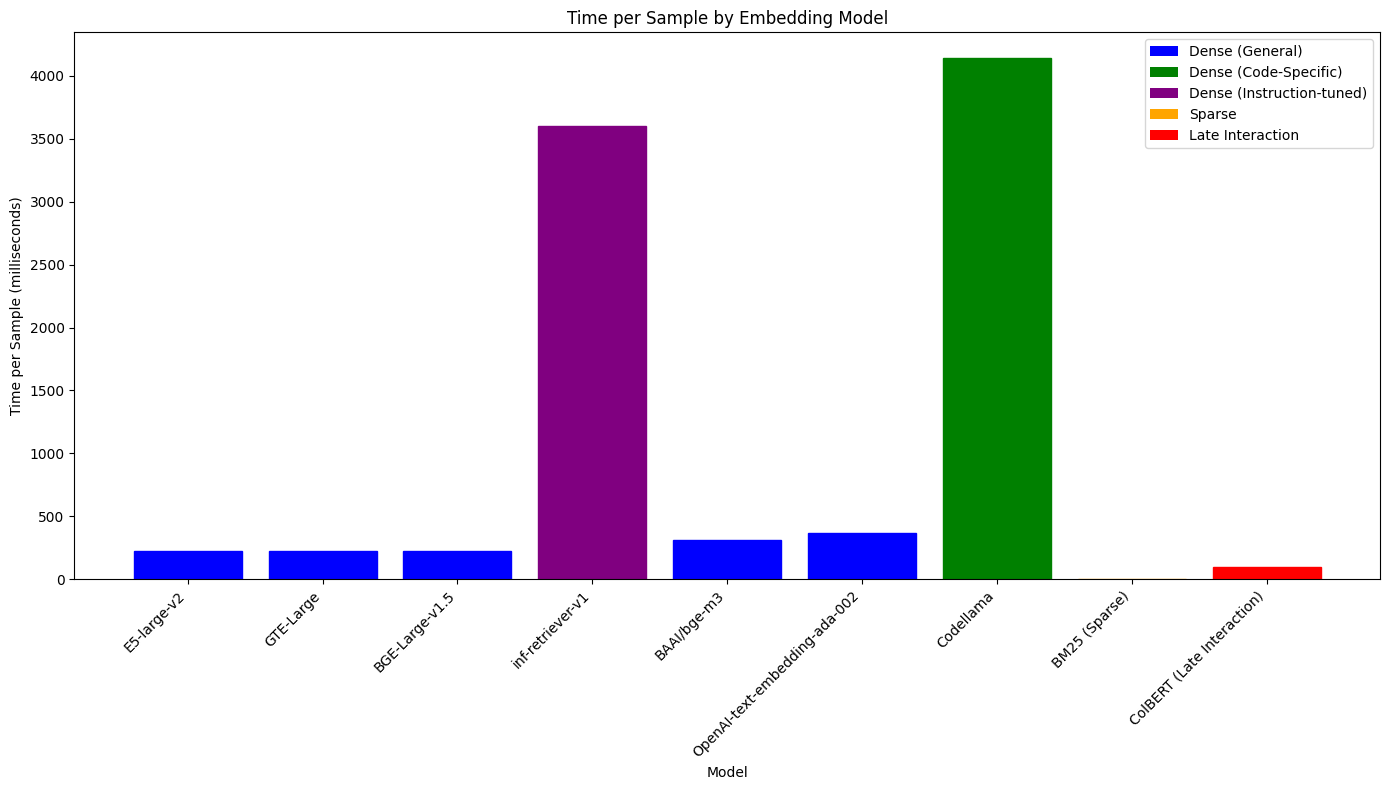

In [28]:
# Create a second visualization showing time per sample
plt.figure(figsize=(14, 8))
# Calculate time per sample
comparison['Time per Sample (ms)'] = (comparison['Generation Time (s)'] * 1000) / comparison['Samples']

bars = plt.bar(comparison['Model'], comparison['Time per Sample (ms)'])

# Color bars by embedding type and code-specificity
for i, bar in enumerate(bars):
    model_type = comparison.iloc[i]['Type']
    is_code_specific = comparison.iloc[i]['Is Code-Specific']
    bar.set_color(colors_map.get((model_type, is_code_specific), 'gray'))

plt.title('Time per Sample by Embedding Model')
plt.ylabel('Time per Sample (milliseconds)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')

# Add a legend for embedding types
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='Dense (General)'),
    Patch(facecolor='green', label='Dense (Code-Specific)'),
    Patch(facecolor='purple', label='Dense (Instruction-tuned)'),
    Patch(facecolor='orange', label='Sparse'),
    Patch(facecolor='red', label='Late Interaction')
]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.savefig('embedding_time_per_sample.png')  # Save the figure
plt.show()

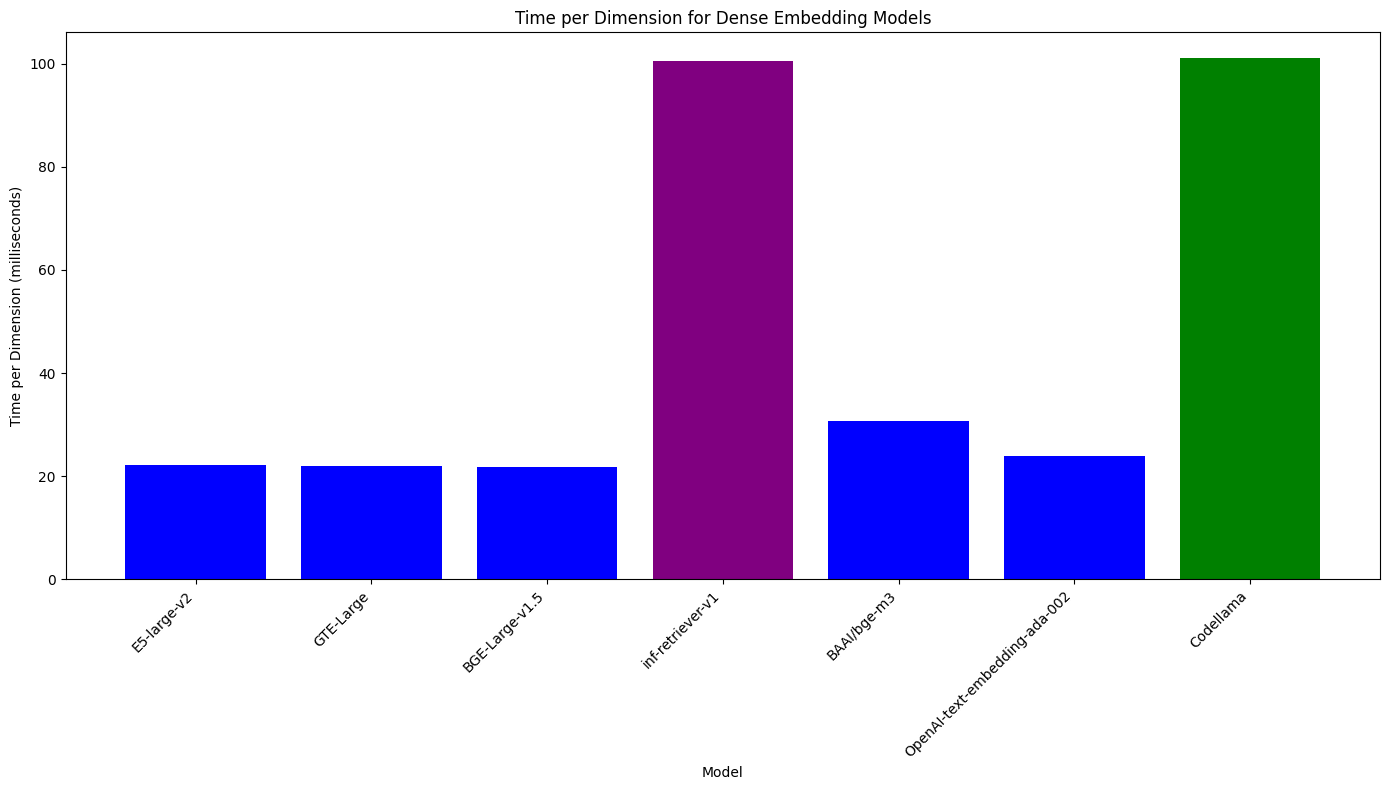

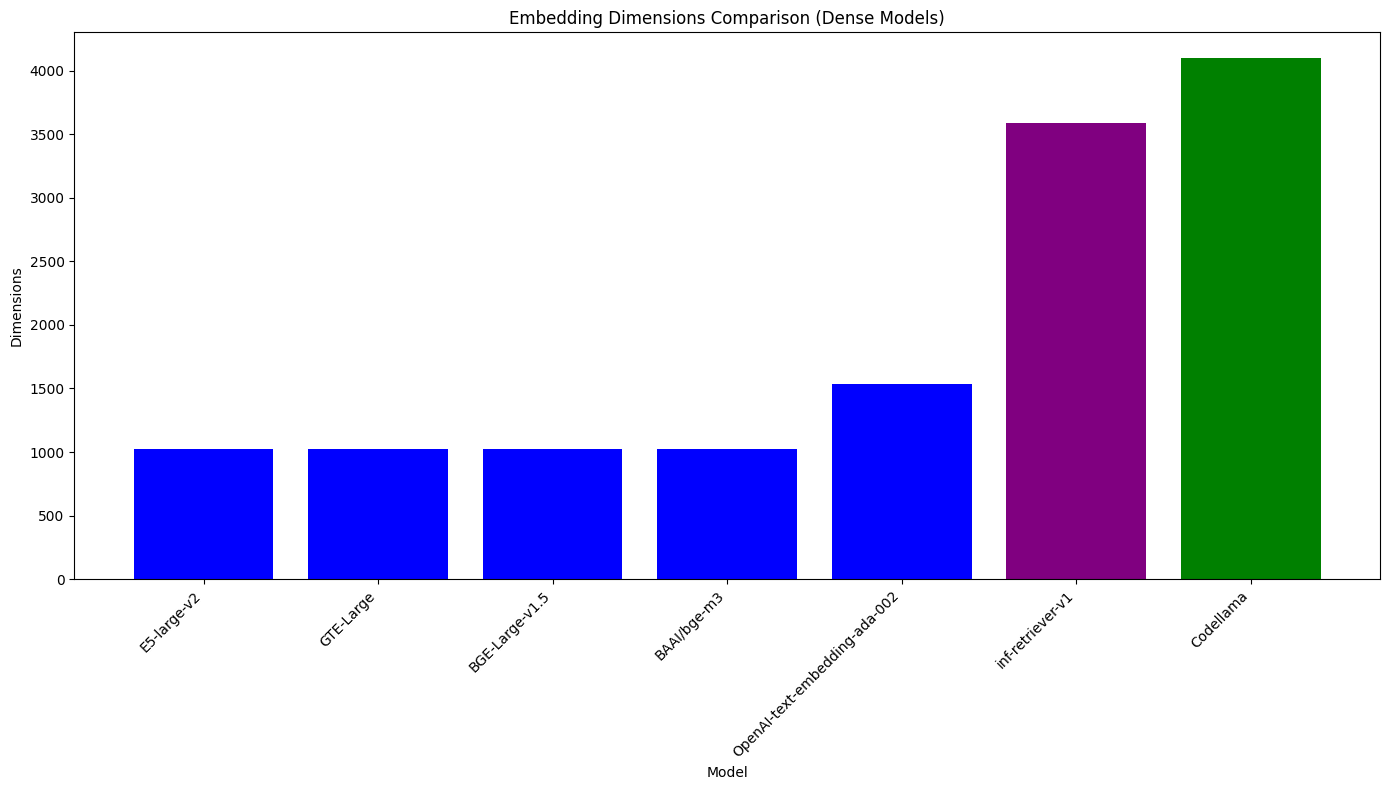

In [29]:
# Create a third visualization for time per dimension (dense embeddings only)
plt.figure(figsize=(14, 8))
# Only show dense embeddings for this plot
dense_models = comparison[comparison['Type'] == 'Dense'].copy()

if 'Time per Dimension (ms)' in dense_models.columns:
    # Create a color map based on code-specificity
    colors = ['blue' if x == 'No' else 'green' if x == 'Yes' else 'purple' for x in dense_models['Is Code-Specific']]
    
    plt.bar(dense_models['Model'], dense_models['Time per Dimension (ms)'], color=colors)
    plt.title('Time per Dimension for Dense Embedding Models')
    plt.ylabel('Time per Dimension (milliseconds)')
    plt.xlabel('Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('dense_embedding_efficiency.png')  # Save the figure
    plt.show()

# Create a fourth visualization specifically comparing dimensions
plt.figure(figsize=(14, 8))
# Filter for only dense models and convert dimension to numeric
dimension_data = comparison[comparison['Type'] == 'Dense'].copy()
dimension_data['Dimension'] = pd.to_numeric(dimension_data['Dimension'], errors='coerce')

# Sort by dimension
dimension_data = dimension_data.sort_values('Dimension')

# Create colors based on code-specificity
colors = ['blue' if x == 'No' else 'green' if x == 'Yes' else 'purple' for x in dimension_data['Is Code-Specific']]

plt.bar(dimension_data['Model'], dimension_data['Dimension'], color=colors)
plt.title('Embedding Dimensions Comparison (Dense Models)')
plt.ylabel('Dimensions')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('embedding_dimensions.png')  # Save the figure
plt.show()

In [30]:
# ## 4. Evaluate Similarity Between Random Samples

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

def evaluate_similarity(embeddings, n_samples=5):
    # For numpy arrays
    if isinstance(embeddings, np.ndarray):
        if embeddings.shape[0] < n_samples:
            return None
        
        # Select random samples
        indices = random.sample(range(embeddings.shape[0]), n_samples)
        selected_embeddings = embeddings[indices]
    
    # For lists (like OpenAI embeddings)
    elif isinstance(embeddings, list):
        if len(embeddings) < n_samples:
            return None
            
        # Select random samples
        indices = random.sample(range(len(embeddings)), n_samples)
        selected_embeddings = [embeddings[i] for i in indices]
        selected_embeddings = np.array(selected_embeddings)  # Convert to numpy for cosine_similarity
    
    else:
        return None
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(selected_embeddings)
    
    # Return average similarity (excluding self-similarity)
    total_sim = 0
    count = 0
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            total_sim += similarity_matrix[i, j]
            count += 1
    
    return total_sim / count if count > 0 else 0

# Calculate average similarity for each model
e5_similarity = evaluate_similarity(e5_embeddings)
gte_similarity = evaluate_similarity(gte_embeddings)
bge_similarity = evaluate_similarity(bge_embeddings)
inf_similarity = evaluate_similarity(inf_embeddings)
bge_m3_similarity = evaluate_similarity(bge_m3_embeddings)
openai_similarity = evaluate_similarity(openai_embeddings)
codellama_similarity = evaluate_similarity(codellama_embeddings)

print("Average similarity between random samples:")
print(f"E5: {e5_similarity:.4f}")
print(f"GTE: {gte_similarity:.4f}")
print(f"BGE: {bge_similarity:.4f}")
print(f"inf_retrival: {inf_similarity:.4f}")
print(f"BGE_m3: {bge_m3_similarity:.4f}")
print(f"OpenAI: {openai_similarity:.4f}")
print(f"codellama: {codellama_similarity:.4f}")


Average similarity between random samples:
E5: 0.8458
GTE: 0.8418
BGE: 0.6701
inf_retrival: 0.7993
BGE_m3: 0.6190
OpenAI: 0.7354
codellama: 0.8056


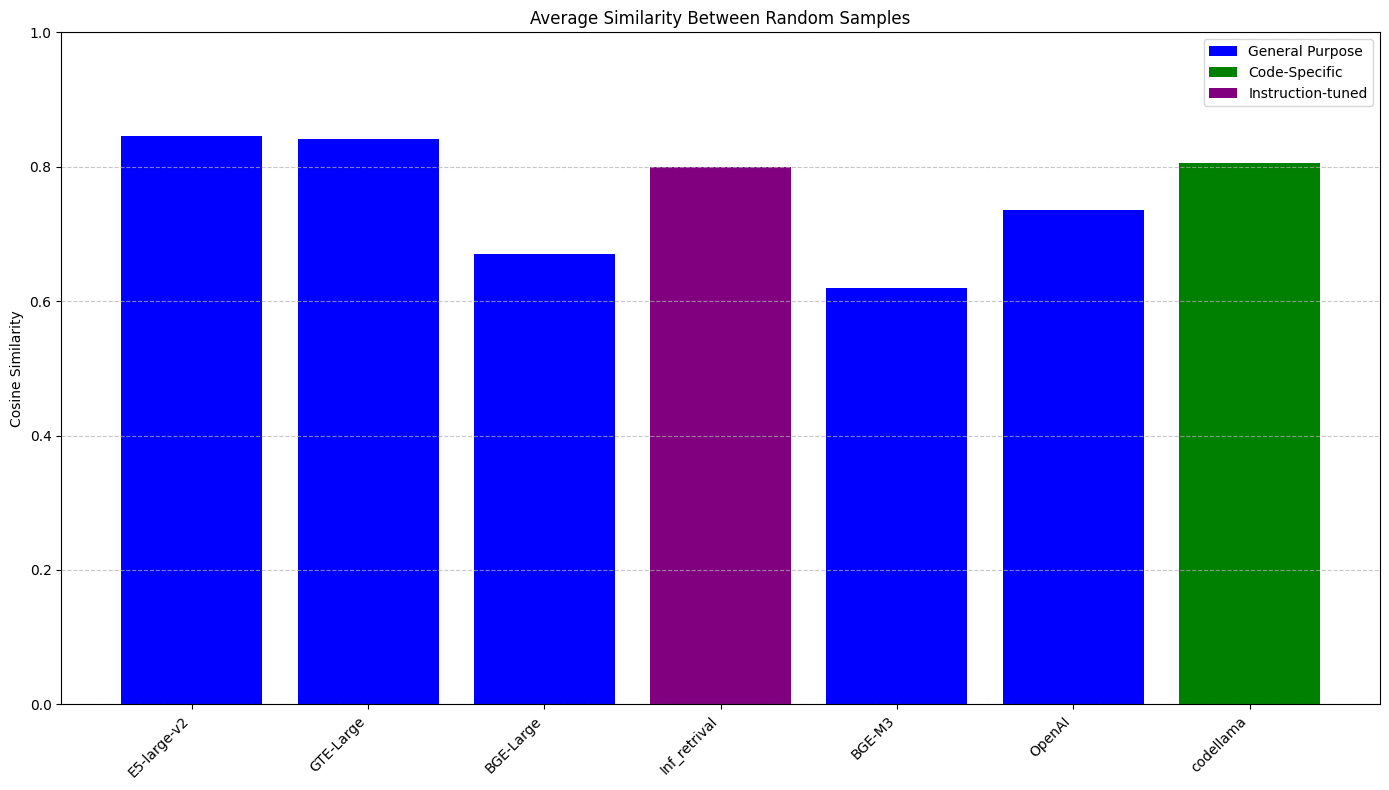

In [31]:
# Visualize similarity comparison
import matplotlib.pyplot as plt

models = ['E5-large-v2', 'GTE-Large', 'BGE-Large', 'Inf_retrival', 'BGE-M3', 'OpenAI', 'codellama']
similarities = [e5_similarity, gte_similarity, bge_similarity, inf_similarity, 
                bge_m3_similarity, openai_similarity, codellama_similarity]

# Define colors based on code-specificity
color_map = {
    'E5-large-v2': 'blue',
    'GTE-Large': 'blue',
    'BGE-Large': 'blue',
    'Inf_retrival': 'purple',
    'BGE-M3': 'blue',
    'OpenAI': 'blue',
    'codellama': 'green'
}
colors = [color_map[model] for model in models]

plt.figure(figsize=(14, 8))
bars = plt.bar(models, similarities, color=colors)
plt.title('Average Similarity Between Random Samples')
plt.ylabel('Cosine Similarity')
plt.ylim(0, 1)  # Cosine similarity ranges from -1 to 1, but typically positive for embeddings
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')

# Add a legend for embedding types
legend_elements = [
    Patch(facecolor='blue', label='General Purpose'),
    Patch(facecolor='green', label='Code-Specific'),
    Patch(facecolor='purple', label='Instruction-tuned')
]
plt.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('embedding_similarity.png')
plt.show()


In [32]:
!pip install qdrant_client

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.7/327.7 KB 1.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 KB 7.8 MB/s eta 0:00:00


In [33]:
# ## 5. Qdrant Setup for Embedding Comparison

import os
import numpy as np
import time
from qdrant_client import QdrantClient
from qdrant_client.http import models

QDRANT_HOST = "localhost"  # If running Docker on the same machine
QDRANT_PORT = 6333  # Default HTTP API port
COLLECTION_NAME = "HIGH_DIM_EMBEDDING_COMPARISON"

print("1. Connecting to Qdrant server in Docker...")
client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT, timeout=10.0)

# Delete existing collection if it exists
try:
    client.delete_collection(collection_name=COLLECTION_NAME)
    print("Existing collection deleted.")
    time.sleep(1)  # Give the server time to process
except Exception:
    print("No existing collection to delete.")

print("2. Creating collection with multiple vector configurations...")
try:
    # Create with named vectors configuration for all models
    # Check if collection exists first
    if client.collection_exists(COLLECTION_NAME):
        client.delete_collection(COLLECTION_NAME)
        print(f"Deleted existing collection {COLLECTION_NAME}")
        time.sleep(1)  # Give server time to process
        
    # Create new collection with named vectors - following sample implementation
    client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config={
            "E5": models.VectorParams(
                size=1024,  # Dimension for E5
                distance=models.Distance.COSINE,
            ),
            "GTE": models.VectorParams(
                size=1024,  # Dimension for GTE
                distance=models.Distance.COSINE,
            ),
            "BGE": models.VectorParams(
                size=1024,  # Dimension for BGE
                distance=models.Distance.COSINE,
            ),
            "INF_RETRIEVER_V1": models.VectorParams(
                size=3584,  # Dimension for Cohere
                distance=models.Distance.COSINE,
            ),
            "BGE_M3": models.VectorParams(
                size=1024,  # Dimension for Instructor
                distance=models.Distance.COSINE,
            ),
            "OpenAI": models.VectorParams(
                size=1536,  # Dimension for OpenAI
                distance=models.Distance.COSINE,
            ),
            "codellama": models.VectorParams(
                size=4096,  # Dimension for CodeLlama
                distance=models.Distance.COSINE,
            ),
            "ColBERT": models.VectorParams(
                size=128,  # Dimension for single ColBERT vector
                distance=models.Distance.COSINE,
                # Configure for late interaction (multiple vectors per document)
                multivector_config=models.MultiVectorConfig(
                    comparator=models.MultiVectorComparator.MAX_SIM,
                )
            ),
        },
        sparse_vectors_config={
            "BM25": models.SparseVectorParams(
                modifier=models.Modifier.IDF,
            )
        }
    )
    print("Collection created successfully!")
    
    # Verify collection was created
    collection_info = client.get_collection(COLLECTION_NAME)
    print(f"Collection status: {collection_info.status}")
    
    # The collection config structure may vary by Qdrant version
    # Print the entire structure to inspect
    print("Collection configuration:")
    print(collection_info)
    
except Exception as e:
    print(f"Failed to create collection: {e}")
    print("Please check Qdrant server connectivity and client version.")
    import sys
    sys.exit(1)  # Exit if we can't create the collection

1. Connecting to Qdrant server in Docker...
Existing collection deleted.
2. Creating collection with multiple vector configurations...
Collection created successfully!
Collection status: green
Collection configuration:
status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=0 segments_count=8 config=CollectionConfig(params=CollectionParams(vectors={'BGE': VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'BGE_M3': VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'ColBERT': VectorParams(size=128, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX

In [34]:
# Define upload_all_embeddings function
def upload_all_embeddings(data, embeddings_dict, batch_size=4):
    """
    Upload embeddings to Qdrant server using named vectors.
    
    Parameters:
    - data: List of dictionaries or DataFrame containing document data
    - embeddings_dict: Dictionary with model names as keys and embedding arrays as values
    - batch_size: Number of points to upload in a single batch
    
    Returns:
    - Boolean indicating success
    """
    total_points = len(data)
    points = []
    
    # Determine the maximum number of points we can process
    max_points = total_points
    for model_name, embeddings in embeddings_dict.items():
        if embeddings is not None:
            if isinstance(embeddings, list) or isinstance(embeddings, np.ndarray):
                max_points = min(max_points, len(embeddings))
    
    print(f"Processing {max_points} points (limited by smallest array)")
    
    # Check if data is a DataFrame or a list
    is_dataframe = hasattr(data, 'iloc')
    
    for i in range(max_points):
        # Create named vector dict for all model embeddings
        vector_dict = {}
        
        # Add dense embeddings (named vectors)
        for model_name, embeddings in embeddings_dict.items():
            if model_name == 'BM25' or model_name == 'ColBERT':
                continue  # Skip special types, handle separately
                
            if embeddings is not None and i < len(embeddings) and embeddings[i] is not None:
                vector_value = embeddings[i].tolist() if hasattr(embeddings[i], 'tolist') else embeddings[i]
                vector_dict[model_name] = vector_value
        
        # Add BM25 sparse embeddings
        if 'BM25' in embeddings_dict and embeddings_dict['BM25'] is not None:
            bm25_embeddings = embeddings_dict['BM25']
            if i < len(bm25_embeddings) and bm25_embeddings[i] is not None:
                # For BM25, try to use as_object() method as shown in the sample
                if hasattr(bm25_embeddings[i], 'as_object'):
                    vector_dict["BM25"] = bm25_embeddings[i].as_object()
                # If no as_object method, but has proper structure
                elif hasattr(bm25_embeddings[i], 'indices') and hasattr(bm25_embeddings[i], 'values'):
                    # Create a compatible format
                    vector_dict["BM25"] = {
                        'indices': bm25_embeddings[i].indices.tolist() if hasattr(bm25_embeddings[i].indices, 'tolist') else bm25_embeddings[i].indices,
                        'values': bm25_embeddings[i].values.tolist() if hasattr(bm25_embeddings[i].values, 'tolist') else bm25_embeddings[i].values
                    }
                # If it's already a dict with indices and values
                elif isinstance(bm25_embeddings[i], dict) and 'indices' in bm25_embeddings[i] and 'values' in bm25_embeddings[i]:
                    vector_dict["BM25"] = bm25_embeddings[i]
                else:
                    print(f"Skipping BM25 for point {i}: format not compatible")
        
        # Add ColBERT late interaction embeddings (multi-vector)
        if 'ColBERT' in embeddings_dict and embeddings_dict['ColBERT'] is not None:
            late_interaction_embeddings = embeddings_dict['ColBERT']
            if i < len(late_interaction_embeddings) and late_interaction_embeddings[i] is not None:
                # For late interaction, we expect a list of vectors (one per token)
                colbert_vectors = late_interaction_embeddings[i]
                # Make sure we have a list of lists
                if isinstance(colbert_vectors, np.ndarray):
                    colbert_vectors = colbert_vectors.tolist()
                # Ensure each vector is a list
                if colbert_vectors and hasattr(colbert_vectors[0], 'tolist'):
                    colbert_vectors = [v.tolist() for v in colbert_vectors]
                vector_dict["ColBERT"] = colbert_vectors
        
        # If we have no vectors, skip this point
        if not vector_dict:
            print(f"Skipping point {i} because no vectors are available")
            continue
            
        # Create payload based on data type
        payload = {}
        
        if is_dataframe and i < len(data):
            row = data.iloc[i]
            text_content = row.get('doc', '') if hasattr(row, 'get') else row['doc'] if 'doc' in row else ""
            payload.update({
                "text": text_content,
                "title": row.get('title', '') if hasattr(row, 'get') else row['title'] if 'title' in row else "",
                "code_snippet": row.get('code_snippet', '') if hasattr(row, 'get') else row['code_snippet'] if 'code_snippet' in row else "",
                "length": row.get('length', 0) if hasattr(row, 'get') else row['length'] if 'length' in row else 0,
                "filename": row.get('filename', '') if hasattr(row, 'get') else row['filename'] if 'filename' in row else ""
            })
        elif not is_dataframe and i < len(data):
            if isinstance(data[i], dict):
                text_content = data[i].get("text", data[i].get("doc", ""))
                payload["text"] = text_content
                
                # Extract metadata directly
                for field in ["title", "code_snippet", "length", "filename"]:
                    if field in data[i]:
                        # Convert numpy types to Python native types
                        if hasattr(data[i][field], 'item'):
                            payload[field] = data[i][field].item()
                        else:
                            payload[field] = data[i][field]
            else:
                payload["text"] = data[i]
        
        # Convert any numpy types to native Python types for JSON serialization
        for key, value in payload.items():
            if hasattr(value, 'item'):
                payload[key] = value.item()
            # Handle string-like numpy objects
            elif hasattr(value, 'decode') and callable(getattr(value, 'decode')):
                try:
                    payload[key] = value.decode('utf-8')
                except:
                    payload[key] = str(value)
        
        # Truncate very long text fields to avoid potential issues with server
        for field in ["text", "title", "code_snippet", "filename"]:
            if field in payload and isinstance(payload[field], str) and len(payload[field]) > 65535:
                payload[field] = payload[field][:65535]
                print(f"Truncated {field} field for point {i} (too long)")
        
        # Create point
        try:
            points.append(models.PointStruct(
                id=i,
                vector=vector_dict,
                payload=payload
            ))
        except Exception as e:
            print(f"Error creating point {i}: {e}")
            if 'BM25' in vector_dict:
                print(f"BM25 type: {type(vector_dict['BM25'])}")
                if isinstance(vector_dict['BM25'], dict):
                    print(f"BM25 keys: {list(vector_dict['BM25'].keys())}")
            continue
        
        # Upload in batches
        if len(points) >= batch_size or i == max_points - 1:
            if points:  # Only upload if we have points
                try:
                    client.upsert(
                        collection_name=COLLECTION_NAME,
                        points=points,
                        wait=True  # Wait for the server to process the points
                    )
                    print(f"Successfully uploaded batch of {len(points)} points to server")
                    points = []
                except Exception as e:
                    print(f"Error uploading batch to server: {e}")
                    if points:
                        print(f"First point in failed batch id: {points[0].id if hasattr(points[0], 'id') else 'Unknown'}")
                    import traceback
                    traceback.print_exc()
                    # Don't immediately return, try to continue with the next batch
                    points = []
    
    return True


In [35]:
# Prepare embeddings dictionary
print("3. Preparing data for upload...")
embeddings_dict = {
    "E5": e5_embeddings,
    "GTE": gte_embeddings,
    "BGE": bge_embeddings,
    "INF_RETRIEVER_V1": inf_embeddings,
    "BGE_M3": bge_m3_embeddings,
    "OpenAI": openai_embeddings,
    "codellama": codellama_embeddings,
    "BM25": bm25_embeddings,
    "ColBERT": late_interaction_embeddings
}

3. Preparing data for upload...


In [36]:
# Create structured_texts from DataFrame
structured_texts = []
for i in range(len(final_dataset)):
    row = final_dataset.iloc[i]
    
    # Convert any numpy types to native Python types
    length_value = row["length"] if "length" in row else 0
    if hasattr(length_value, 'item'):
        length_value = length_value.item()
    
    structured_texts.append({
        "text": row["doc"] if "doc" in row else "",
        "title": row["title"] if "title" in row else "",
        "code_snippet": row["code_snippet"] if "code_snippet" in row else "",
        "length": length_value,
        "filename": row["filename"] if "filename" in row else ""
    })

# Define how many samples to use (limited to 100 for demonstration)
max_samples = min(100, len(structured_texts))

# Create subset of data
subset_texts = structured_texts[:max_samples]

print(f"Using {max_samples} samples for upload")

Using 100 samples for upload


In [37]:
# Upload the embeddings
print("4. Uploading embeddings to Qdrant...")
upload_success = upload_all_embeddings(
    subset_texts,
    embeddings_dict,
    batch_size=4  # Reduced batch size for complex vectors
)

if upload_success:
    print("All embeddings uploaded successfully to Qdrant server")
else:
    print("There were issues during the upload process")

4. Uploading embeddings to Qdrant...
Processing 100 points (limited by smallest array)
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully uploaded batch of 4 points to server
Successfully 

In [38]:
# Verify upload and optimize collection
print("5. Verifying upload and optimizing collection...")
try:
    # Verify collection status
    collection_info = client.get_collection(COLLECTION_NAME)
    print(f"Collection points count: {collection_info.points_count}")
    
    # Force collection optimization
    print("Forcing collection optimization...")
    client.update_collection(
        collection_name=COLLECTION_NAME,
        optimizers_config=models.OptimizersConfigDiff(
            indexing_threshold=0  # Force immediate indexing
        )
    )
    print("Optimization requested")
    
    # Wait for indexing
    print("Waiting for indexing to complete...")
    time.sleep(5)
    
    # Check updated collection status
    collection_info = client.get_collection(COLLECTION_NAME)
    print(f"Updated points count: {collection_info.points_count}")
    
    # Count points directly
    count_response = client.count(collection_name=COLLECTION_NAME)
    print(f"Actual points count: {count_response.count}")
    
    # Print a sample search to verify everything works
    print("\nTesting search with E5 vector...")
    if isinstance(e5_embeddings, np.ndarray) and e5_embeddings.shape[0] > 0:
        search_result = client.search(
            collection_name=COLLECTION_NAME,
            query_vector=("E5", e5_embeddings[0].tolist()),
            limit=3
        )
        print(f"Search returned {len(search_result)} results")
        
    print("\nProcess completed successfully!")
    
except Exception as e:
    print(f"Error during verification or optimization: {e}")

5. Verifying upload and optimizing collection...
Collection points count: 100
Forcing collection optimization...
Optimization requested
Waiting for indexing to complete...
Updated points count: 100
Actual points count: 100

Testing search with E5 vector...
Search returned 3 results

Process completed successfully!


/tmp/ipykernel_23188/4059328617.py:33: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search(


In [39]:
!pip install ranx

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 KB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 KB 9.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 KB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 KB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 39.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.8 MB/s eta 0:00:00:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [40]:
# ## 6. Retrieval Evaluation Framework

# Load queries and ground truth data
import json
from collections import defaultdict
from ranx import Qrels

# Path to your generated ground truth data
qrels_path = "qrels_beir.json"

# Load the BeIR format qrels
with open(qrels_path, 'r') as f:
    query_qrels = json.load(f)

# Print a sample entry
print("Sample qrels entry:")
print(query_qrels[7])

# Convert to ranx format
qrels_dict = defaultdict(dict)
for entry in query_qrels:
    query_id = str(entry["query-id"])
    doc_id = str(entry["corpus-id"])
    qrels_dict[query_id][doc_id] = entry["score"]

# Create ranx Qrels object
qrels = Qrels(qrels_dict, name="sap_abap")
print("\nQrels object created:")
print(qrels)

# Load queries from JSON
queries_path = "queries.json"
with open(queries_path, 'r') as f:
    queries_dict = json.load(f)

# Convert to list format with _id field
queries = []
for query_id, query_data in queries_dict.items():
    queries.append({
        "_id": query_id,
        "text": query_data["text"]
    })

print(f"Loaded {len(queries)} queries")

Sample qrels entry:
{'query-id': 7, 'corpus-id': 3, 'score': 1}

Qrels object created:
{0: {0: 1}, 1: {0: 1}, 10: {5: 1}, 100: {50: 1}, 101: {50: 1}, 102: {51: 1}, 103: {51: 1}, 104: {52: 1}, 105: {52: 1}, 106: {53: 1}, 107: {53: 1}, 108: {54: 1}, 109: {54: 1}, 11: {5: 1}, 110: {55: 1}, 111: {55: 1}, 112: {56: 1}, 113: {56: 1}, 114: {57: 1}, 115: {57: 1}, 116: {58: 1}, 117: {58: 1}, 118: {59: 1}, 119: {59: 1}, 12: {6: 1}, 120: {60: 1}, 121: {60: 1}, 122: {61: 1}, 123: {61: 1}, 124: {62: 1}, 125: {62: 1}, 126: {63: 1}, 127: {63: 1}, 128: {64: 1}, 129: {64: 1}, 13: {6: 1}, 130: {65: 1}, 131: {65: 1}, 132: {66: 1}, 133: {66: 1}, 134: {67: 1}, 135: {67: 1}, 136: {68: 1}, 137: {68: 1}, 138: {69: 1}, 139: {69: 1}, 14: {7: 1}, 140: {70: 1}, 141: {70: 1}, 142: {71: 1}, 143: {71: 1}, 144: {72: 1}, 145: {72: 1}, 146: {73: 1}, 147: {73: 1}, 148: {74: 1}, 149: {74: 1}, 15: {7: 1}, 150: {75: 1}, 151: {75: 1}, 152: {76: 1}, 153: {76: 1}, 154: {77: 1}, 155: {77: 1}, 156: {78: 1}, 157: {78: 1}, 158: {

In [41]:
# ## 7. Precompute Query Embeddings for All Models

# Function to precompute embeddings for all queries and models
def precompute_query_embeddings(queries, models):
    """
    Precompute embeddings for all queries across multiple models.
    
    Args:
        queries: List of query objects with 'text' field
        models: Dictionary of embedding models keyed by model name
    
    Returns:
        Dictionary of embeddings organized by model type and name
    """
    # Ensure queries is a list of dictionaries
    if isinstance(queries[0], str):
        print("Converting queries from strings to dictionaries...")
        queries = [{"_id": str(i), "text": query} for i, query in enumerate(queries)]
    
    # Initialize dictionary to store embeddings by type
    embeddings = {
        'dense_embeddings': {},
        'sparse_embeddings': {},
        'late_interaction_embeddings': {}
    }
    
    print("Precomputing query embeddings...")
    
    # Import tqdm correctly
    from tqdm import tqdm
    
    # Process dense models
    dense_models = ['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1', 'BGE_M3', 'OpenAI', 'codellama']
    for model_name in dense_models:
        if model_name in models:
            print(f"Processing {model_name} embeddings...")
            model_vectors = []
            
            for query in tqdm(queries):
                # Special handling for Instructor model (requires prompt)
                if model_name == 'INF_RETRIEVER_V1':
                    query_vector = models[model_name].encode([["Represent code for retrieval: ", query["text"]]])
                else:
                    # Use encode for SentenceTransformer models
                    query_vector = models[model_name].encode(query["text"])
                model_vectors.append(query_vector)
            
            embeddings['dense_embeddings'][model_name] = model_vectors
    
    # Process sparse model (BM25)
    if 'BM25' in models:
        print("Processing BM25 sparse embeddings...")
        sparse_vectors = []
        
        for query in tqdm(queries):
            # Use query_embed for fastembed models
            sparse_vector = next(models['BM25'].query_embed(query["text"]))
            sparse_vectors.append(sparse_vector)
        
        embeddings['sparse_embeddings']['BM25'] = sparse_vectors
    
    # Process late interaction model (ColBERT)
    if 'ColBERT' in models:
        print("Processing ColBERT late interaction embeddings...")
        late_vectors = []
        
        for query in tqdm(queries):
            # Use query_embed for fastembed models
            late_vector = next(models['ColBERT'].query_embed(query["text"]))
            late_vectors.append(late_vector)
        
        embeddings['late_interaction_embeddings']['ColBERT'] = late_vectors
    
    print("Embeddings precomputation complete!")
    return embeddings


In [42]:
# Initialize models dictionary
models = {
    'E5': e5_model,
    'GTE': gte_model,
    'BGE': bge_model,
    'INF_RETRIEVER_V1': inf_model,  # Simulated, would require API client
    'BGE_M3': bge_m3_model,
    'OpenAI': openai_model,
    'codellama':codellama_model,
    'BM25': bm25_embedding_model,
    'ColBERT': late_interaction_embedding_model
}

In [43]:
# Precompute embeddings
embeddings = precompute_query_embeddings(queries, models)

Precomputing query embeddings...
Processing E5 embeddings...


100%|██████████| 200/200 [00:31<00:00,  6.30it/s]


Processing GTE embeddings...


100%|██████████| 200/200 [00:29<00:00,  6.80it/s]


Processing BGE embeddings...


100%|██████████| 200/200 [00:30<00:00,  6.52it/s]


Processing INF_RETRIEVER_V1 embeddings...


100%|██████████| 200/200 [07:03<00:00,  2.12s/it]


Processing BGE_M3 embeddings...


100%|██████████| 200/200 [00:28<00:00,  6.95it/s]


Processing OpenAI embeddings...


100%|██████████| 200/200 [00:58<00:00,  3.43it/s]


Processing codellama embeddings...


100%|██████████| 200/200 [06:54<00:00,  2.07s/it]


Processing BM25 sparse embeddings...


100%|██████████| 200/200 [00:00<00:00, 28816.93it/s]


Processing ColBERT late interaction embeddings...


100%|██████████| 200/200 [00:04<00:00, 46.61it/s]

Embeddings precomputation complete!


In [44]:
# Before your evaluation code, check your embeddings dictionary structure
print("Embeddings dictionary keys:", embeddings.keys())
if 'dense_embeddings' in embeddings:
    print("Dense embeddings keys:", embeddings['dense_embeddings'].keys())
else:
    print("No 'dense_embeddings' key found. Creating it now...")
    # If embeddings is a flat dictionary, create the nested structure
    dense_embeddings = {}
    for key in embeddings.keys():
        if key not in ['sparse_embeddings', 'late_interaction_embeddings']:
            dense_embeddings[key] = embeddings[key]
    
    # Create the nested structure
    embeddings = {
        'dense_embeddings': dense_embeddings,
        'sparse_embeddings': {},
        'late_interaction_embeddings': {}
    }
    
    # Make sure starcoder is in the dense embeddings
    if 'codellama' not in embeddings['dense_embeddings'] and 'codellama_embeddings' in globals():
        embeddings['dense_embeddings']['codellama'] = codellama_embeddings
        print("Added codellama embeddings to the dictionary")

Embeddings dictionary keys: dict_keys(['dense_embeddings', 'sparse_embeddings', 'late_interaction_embeddings'])
Dense embeddings keys: dict_keys(['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1', 'BGE_M3', 'OpenAI', 'codellama'])


In [45]:
# ## 8. Retrieval Evaluation for All Models

from ranx import Run, evaluate, compare
from qdrant_client.models import SparseVector, FusionQuery, Fusion, Prefetch

# Evaluate individual models
from tqdm import tqdm

# Define models that have real embeddings (not simulated)
real_models = ['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1', 'BGE_M3','OpenAI','codellama']
dense_runs = {}
# Evaluate individual models
print("Evaluating individual dense models...")
for model_name in tqdm(real_models):
    dense_run_dict = {}
    for query_idx, query in enumerate(queries):
        query_id = str(query["_id"])
        query_vector = embeddings['dense_embeddings'][model_name][query_idx]
        
        # Fix INF_RETRIEVER_V1 dimensionality (remove the extra dimension)
        if model_name == 'INF_RETRIEVER_V1' and isinstance(query_vector, np.ndarray) and len(query_vector.shape) > 1:
            query_vector = query_vector.reshape(-1)  # Flatten to 1D array
            
        # Fix for OpenAI embeddings which seem to be a list containing the actual embedding
        if model_name == 'OpenAI':
            if isinstance(query_vector, list) and len(query_vector) == 1:
                # If it's a list with one item, extract that item
                query_vector = query_vector[0]
            elif isinstance(query_vector, list) and len(query_vector) > 1:
                # If it's already a flattened vector in list form, keep as is
                pass
            # Ensure it's a list for JSON serialization
            if isinstance(query_vector, np.ndarray):
                query_vector = query_vector.tolist()
        
        # Convert numpy arrays to lists for JSON serialization
        if isinstance(query_vector, np.ndarray):
            query_vector = query_vector.tolist()
        
        try:
            results = client.query_points(
                COLLECTION_NAME,
                query=query_vector,
                using=model_name,
                with_payload=False,
                limit=10,
            )
            
            dense_run_dict[query_id] = {
                str(point.id): point.score
                for point in results.points
            }
        except Exception as e:
            print(f"Error querying with {model_name} for query {query_id}: {e}")
            # Add more debugging info
            if model_name == 'OpenAI':
                print(f"OpenAI vector type: {type(query_vector)}")
                if isinstance(query_vector, list):
                    print(f"OpenAI vector length: {len(query_vector)}")
                    if len(query_vector) > 0:
                        print(f"First element type: {type(query_vector[0])}")
            continue
    
    # Only create Run objects for models with results
    if dense_run_dict:
        dense_runs[model_name] = Run(dense_run_dict, name=f"{model_name}_dense")
    else:
        print(f"No successful queries for {model_name}, skipping Run creation")

Evaluating individual dense models...


100%|██████████| 7/7 [00:28<00:00,  4.13s/it]


In [46]:
# Filter out any models not present in the dense embeddings
real_models = [m for m in real_models if m in embeddings['dense_embeddings']]
real_models

['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1', 'BGE_M3', 'OpenAI', 'codellama']

In [47]:
# Evaluate BM25 sparse model
print("Evaluating BM25 sparse model...")
bm25_run_dict = {}
for query_idx, query in enumerate(tqdm(queries)):
    query_id = str(query["_id"])
    sparse_query_vector = embeddings['sparse_embeddings']['BM25'][query_idx]
    
    if hasattr(sparse_query_vector, 'indices') and hasattr(sparse_query_vector, 'values'):
        sparse_query_vector = SparseVector(
            indices=sparse_query_vector.indices.tolist(),
            values=sparse_query_vector.values.tolist()
        )
    else:
        print(f"Skipping query {query_idx}: Invalid BM25 vector format")
        continue
    
    results = client.query_points(
        COLLECTION_NAME,
        query=sparse_query_vector,
        using="BM25",
        with_payload=False,
        limit=10,
    )
    
    bm25_run_dict[query_id] = {
        str(point.id): point.score
        for point in results.points
    }

bm25_run = Run(bm25_run_dict, name="BM25_sparse")

Evaluating BM25 sparse model...


100%|██████████| 200/200 [00:00<00:00, 250.79it/s]


In [48]:
# Evaluate ColBERT late interaction model
print("Evaluating ColBERT late interaction model...")
colbert_run_dict = {}
for query_idx, query in enumerate(tqdm(queries)):
    query_id = str(query["_id"])
    late_query_vector = embeddings['late_interaction_embeddings']['ColBERT'][query_idx]
    
    results = client.query_points(
        COLLECTION_NAME,
        query=late_query_vector,
        using="ColBERT",
        with_payload=False,
        limit=10,
    )
    
    colbert_run_dict[query_id] = {
        str(point.id): point.score
        for point in results.points
    }

colbert_run = Run(colbert_run_dict, name="ColBERT_late")

Evaluating ColBERT late interaction model...


100%|██████████| 200/200 [00:08<00:00, 22.41it/s]


In [49]:
# Evaluate hybrid models with BM25
print("Evaluating hybrid models (dense + BM25)...")
rrf_runs = {}

# Create combinations of each dense model with BM25
hybrid_combinations = [f"{model}+BM25" for model in real_models]

for combination in tqdm(hybrid_combinations):
    dense_model_name = combination.split('+')[0]
    rrf_run_dict = {}
    
    for query_idx, query in enumerate(queries):
        query_id = str(query["_id"])
        dense_query_vector = embeddings['dense_embeddings'][dense_model_name][query_idx]
        sparse_query_vector = embeddings['sparse_embeddings']['BM25'][query_idx]
        
        # Fix INF_RETRIEVER_V1 dimensionality (remove the extra dimension)
        if dense_model_name == 'INF_RETRIEVER_V1' and isinstance(dense_query_vector, np.ndarray) and len(dense_query_vector.shape) > 1:
            dense_query_vector = dense_query_vector.reshape(-1)  # Flatten to 1D array
            
        # Fix for OpenAI embeddings 
        if dense_model_name == 'OpenAI':
            if isinstance(dense_query_vector, list) and len(dense_query_vector) == 1:
                # If it's a list with one item, extract that item
                dense_query_vector = dense_query_vector[0]
            elif isinstance(dense_query_vector, list) and len(dense_query_vector) > 1:
                # If it's already a flattened vector in list form, keep as is
                pass
        
        # Convert numpy arrays to lists for JSON serialization
        if isinstance(dense_query_vector, np.ndarray):
            dense_query_vector = dense_query_vector.tolist()
        
        # Prepare sparse vector
        if hasattr(sparse_query_vector, 'indices') and hasattr(sparse_query_vector, 'values'):
            sparse_query_vector = SparseVector(
                indices=sparse_query_vector.indices.tolist(),
                values=sparse_query_vector.values.tolist()
            )
        else:
            print(f"Skipping query {query_idx}: Invalid BM25 vector format")
            continue
        
        try:
            prefetch_queries = [
                Prefetch(
                    query=dense_query_vector,
                    using=dense_model_name,
                    limit=20,
                ),
                Prefetch(
                    query=sparse_query_vector,
                    using="BM25",
                    limit=20,
                ),
            ]
            
            results = client.query_points(
                COLLECTION_NAME,
                prefetch=prefetch_queries,
                query=FusionQuery(
                    fusion=Fusion.RRF,
                ),
                with_payload=False,
                limit=10,
            )
            
            rrf_run_dict[query_id] = {
                str(point.id): point.score
                for point in results.points
            }
        except Exception as e:
            print(f"Error with hybrid fusion {combination} for query {query_id}: {e}")
            # Add more debugging info
            if dense_model_name == 'OpenAI':
                print(f"OpenAI vector type: {type(dense_query_vector)}")
                if isinstance(dense_query_vector, list):
                    print(f"OpenAI vector length: {len(dense_query_vector)}")
            continue
    
    # Only create Run objects for combinations with results
    if rrf_run_dict:
        rrf_runs[combination] = Run(rrf_run_dict, name=combination)
    else:
        print(f"No successful queries for {combination}, skipping Run creation")

Evaluating hybrid models (dense + BM25)...


100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


In [50]:
print("Evaluating fusion of all models...")
full_rrf_run_dict = {}

for query_idx, query in enumerate(tqdm(queries)):
    query_id = str(query["_id"])
    
    try:
        # Get all dense embeddings for this query and preprocess them
        dense_query_vectors = {}
        for model_name in real_models:
            vector = embeddings['dense_embeddings'][model_name][query_idx]
            
            # Fix INF_RETRIEVER_V1 dimensionality (remove the extra dimension)
            if model_name == 'INF_RETRIEVER_V1' and isinstance(vector, np.ndarray) and len(vector.shape) > 1:
                vector = vector.reshape(-1)  # Flatten to 1D array
                
            # Fix for OpenAI embeddings
            if model_name == 'OpenAI':
                if isinstance(vector, list) and len(vector) == 1:
                    # If it's a list with one item, extract that item
                    vector = vector[0]
                elif isinstance(vector, list) and len(vector) > 1:
                    # If it's already a flattened vector in list form, keep as is
                    pass
            
            # Convert numpy arrays to lists for JSON serialization
            if isinstance(vector, np.ndarray):
                vector = vector.tolist()
                
            dense_query_vectors[model_name] = vector
        
        # Get and prepare sparse vector
        sparse_query_vector = embeddings['sparse_embeddings']['BM25'][query_idx]
        if hasattr(sparse_query_vector, 'indices') and hasattr(sparse_query_vector, 'values'):
            sparse_query_vector = SparseVector(
                indices=sparse_query_vector.indices.tolist(),
                values=sparse_query_vector.values.tolist()
            )
        else:
            print(f"Skipping query {query_idx}: Invalid BM25 vector format")
            continue
        
        # Get late interaction vector
        late_query_vector = embeddings['late_interaction_embeddings']['ColBERT'][query_idx]
        
        # Create prefetch queries for all models
        prefetch_queries = [
            Prefetch(
                query=dense_query_vectors[model_name],
                using=model_name,
                limit=20,
            )
            for model_name in real_models
        ] + [
            Prefetch(
                query=sparse_query_vector,
                using="BM25",
                limit=20,
            ),
            Prefetch(
                query=late_query_vector,
                using="ColBERT",
                limit=20,
            ),
        ]
        
        results = client.query_points(
            COLLECTION_NAME,
            prefetch=prefetch_queries,
            query=FusionQuery(
                fusion=Fusion.RRF,
            ),
            with_payload=False,
            limit=10,
        )
        
        full_rrf_run_dict[query_id] = {
            str(point.id): point.score
            for point in results.points
        }
    except Exception as e:
        print(f"Error with full fusion for query {query_id}: {e}")
        # Print more details about the vectors to help diagnose the issue
        for model_name in real_models:
            vector = dense_query_vectors.get(model_name)
            if vector:
                print(f"{model_name} vector type: {type(vector)}")
                if isinstance(vector, list):
                    print(f"{model_name} vector length: {len(vector)}")
        continue

# Only create Run object if we have results
if full_rrf_run_dict:
    full_rrf_run = Run(full_rrf_run_dict, name="Full_RRF")
else:
    print("No successful queries for full fusion, skipping Run creation")

Evaluating fusion of all models...


100%|██████████| 200/200 [00:14<00:00, 13.60it/s]


In [51]:
# Define high-dimensional models with real embeddings (not simulated)
high_dim_models = ['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1' ,'codellama', 'OpenAI']

# Create fusion of high-dimensional models
print("Evaluating fusion of high-dimensional models...")
high_dim_fusion_run_dict = {}

for query_idx, query in enumerate(tqdm(queries)):
    query_id = str(query["_id"])
    
    try:
        # Get all high-dimensional embeddings for this query and preprocess them
        high_dim_query_vectors = {}
        for model_name in high_dim_models:
            if model_name not in embeddings['dense_embeddings']:
                print(f"Skipping {model_name} - not in embeddings dictionary")
                continue
                
            vector = embeddings['dense_embeddings'][model_name][query_idx]
            
            # Fix INF_RETRIEVER_V1 dimensionality (remove the extra dimension)
            if model_name == 'INF_RETRIEVER_V1' and isinstance(vector, np.ndarray) and len(vector.shape) > 1:
                vector = vector.reshape(-1)  # Flatten to 1D array
                
            # Fix for OpenAI embeddings
            if model_name == 'OpenAI':
                if isinstance(vector, list) and len(vector) == 1:
                    # If it's a list with one item, extract that item
                    vector = vector[0]
                elif isinstance(vector, list) and len(vector) > 1:
                    # If it's already a flattened vector in list form, keep as is
                    pass
            
            # Convert numpy arrays to lists for JSON serialization
            if isinstance(vector, np.ndarray):
                vector = vector.tolist()
                
            high_dim_query_vectors[model_name] = vector
            
        # Create prefetch queries for all available high-dimensional models
        prefetch_queries = []
        for model_name in high_dim_models:
            if model_name in high_dim_query_vectors:
                prefetch_queries.append(
                    Prefetch(
                        query=high_dim_query_vectors[model_name],
                        using=model_name,
                        limit=20,
                    )
                )
        
        # Only proceed if we have at least one valid prefetch query
        if not prefetch_queries:
            print(f"Skipping query {query_idx}: No valid prefetch queries")
            continue
            
        results = client.query_points(
            COLLECTION_NAME,
            prefetch=prefetch_queries,
            query=FusionQuery(
                fusion=Fusion.RRF,
            ),
            with_payload=False,
            limit=10,
        )
        
        high_dim_fusion_run_dict[query_id] = {
            str(point.id): point.score
            for point in results.points
        }
    except Exception as e:
        print(f"Error with high-dim fusion for query {query_id}: {e}")
        # Print more details about the vectors to help diagnose the issue
        for model_name, vector in high_dim_query_vectors.items():
            print(f"{model_name} vector type: {type(vector)}")
            if isinstance(vector, list):
                print(f"{model_name} vector length: {len(vector)}")
        continue

# Only create Run object if we have results
if high_dim_fusion_run_dict:
    high_dim_fusion_run = Run(high_dim_fusion_run_dict, name="HighDim_Fusion")
else:
    print("No successful queries for high-dimensional fusion, skipping Run creation")

Evaluating fusion of high-dimensional models...


100%|██████████| 200/200 [00:10<00:00, 18.45it/s]


In [52]:
# ## 9. Evaluate Instructor with Different Prompts
print("Evaluating Instructor with different prompts...")
instructor_runs = {}

# Define different instruction prompts for code retrieval
instruction_prompts = {
    "Basic": "Represent code for retrieval: ",
    "Detailed": "Represent this code snippet for semantic code search, focusing on functionality, variable names, and programming patterns: ",
    "Function": "Represent this code to find similar functions and implementations: ",
    "Documentation": "Represent this code to match with relevant documentation and usage examples: "
}

# Precompute Instructor embeddings with different prompts
instructor_prompt_embeddings = {}
for prompt_name, prompt_text in instruction_prompts.items():
    print(f"Computing Instructor embeddings with {prompt_name} prompt...")
    prompt_vectors = []
    
    for query in tqdm(queries):
        query_text = query["text"]
        # Format with the specific instruction prompt
        prompt_vector = inf_model.encode([[prompt_text, query_text]])
        prompt_vectors.append(prompt_vector)
    
    instructor_prompt_embeddings[prompt_name] = prompt_vectors

# Evaluate each prompt variation
for prompt_name, prompt_vectors in instructor_prompt_embeddings.items():
    prompt_run_dict = {}
    
    for query_idx, query in enumerate(tqdm(queries)):
        query_id = str(query["_id"])
        query_vector = prompt_vectors[query_idx]
        
        try:
            # Fix dimensionality - this is crucial
            if isinstance(query_vector, np.ndarray) and len(query_vector.shape) > 1:
                # If shape is (1, 3584), flatten to (3584,)
                query_vector = query_vector.reshape(-1)
            
            # Convert to list for JSON serialization if needed
            if isinstance(query_vector, np.ndarray):
                query_vector = query_vector.tolist()
            
            results = client.query_points(
                COLLECTION_NAME,
                query=query_vector,
                using="INF_RETRIEVER_V1",
                with_payload=False,
                limit=10,
            )
            
            prompt_run_dict[query_id] = {
                str(point.id): point.score
                for point in results.points
            }
        except Exception as e:
            print(f"Error with {prompt_name} prompt for query {query_id}: {e}")
            print(f"Query vector shape: {query_vector.shape if hasattr(query_vector, 'shape') else 'N/A'}")
            print(f"Query vector type: {type(query_vector)}")
            continue
    
    # Only create Run object if we have results
    if prompt_run_dict:
        instructor_runs[prompt_name] = Run(prompt_run_dict, name=f"Instructor_{prompt_name}")
    else:
        print(f"No successful queries for {prompt_name} prompt, skipping Run creation")

Evaluating Instructor with different prompts...
Computing Instructor embeddings with Basic prompt...


100%|██████████| 200/200 [07:00<00:00,  2.10s/it]


Computing Instructor embeddings with Detailed prompt...


100%|██████████| 200/200 [09:08<00:00,  2.74s/it]


Computing Instructor embeddings with Function prompt...


100%|██████████| 200/200 [07:49<00:00,  2.35s/it]


Computing Instructor embeddings with Documentation prompt...


100%|██████████| 200/200 [00:05<00:00, 34.50it/s]


In [53]:
# ## 10. Compare All Models and Combinations

# Collect all runs for comparison
runs_to_compare = (
    list(dense_runs.values()) +  # Individual dense models
    [bm25_run, colbert_run] +    # BM25 and ColBERT
    list(rrf_runs.values()) +    # Hybrid combinations
    [high_dim_fusion_run] +      # High-dimensional fusion
    list(instructor_runs.values()) +  # Instructor with different prompts
    [full_rrf_run]               # Full fusion
)

In [69]:
# Define comprehensive metrics
metrics = ["precision@10", "recall@10", "mrr@10", "ndcg@10"]

# Run the comparison
print("Running comprehensive comparison of all models and combinations...")
comparison_results = compare(
    qrels=qrels,
    runs=runs_to_compare,
    metrics=metrics,
)

print(comparison_results)

# ## 11. Visualize Results

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert comparison results to DataFrame for visualization
results_df = comparison_results.to_dataframe()


Running comprehensive comparison of all models and combinations...
#    Model                     P@10            Recall@10       MRR@10    NDCG@10
---  ------------------------  --------------  --------------  --------  ---------
a    E5_dense                  0.013ᵇ۹ᵛ        0.125ᵇ۹ᵛ        0.033ᵇᵒ   0.054ᵇ۹
b    GTE_dense                 0.005           0.050           0.018     0.026
c    BGE_dense                 0.007           0.070           0.018     0.030
d    INF_RETRIEVER_V1_dense    0.009           0.090           0.029     0.043
e    BGE_M3_dense              0.011ᵇ          0.110ᵇ          0.039     0.055ᵇ
f    OpenAI_dense              0.009           0.095           0.024     0.040
g    codellama_dense           0.012ᵇ۹         0.120ᵇ۹         0.029     0.050
h    BM25_sparse               0.014ᵇᶜᵏˡᵒ۹ᵗᵘᵛ  0.145ᵇᶜᵏˡᵒ۹ᵗᵘᵛ  0.031     0.056ᵇᵏˡᵒ
i    ColBERT_late              0.012ᵇ۹         0.115ᵇ۹         0.044ᵇ    0.060ᵇᵏᵒ۹
j    E5+BM25                   0.011           

Results saved to 'embedding_model_comparison.csv'


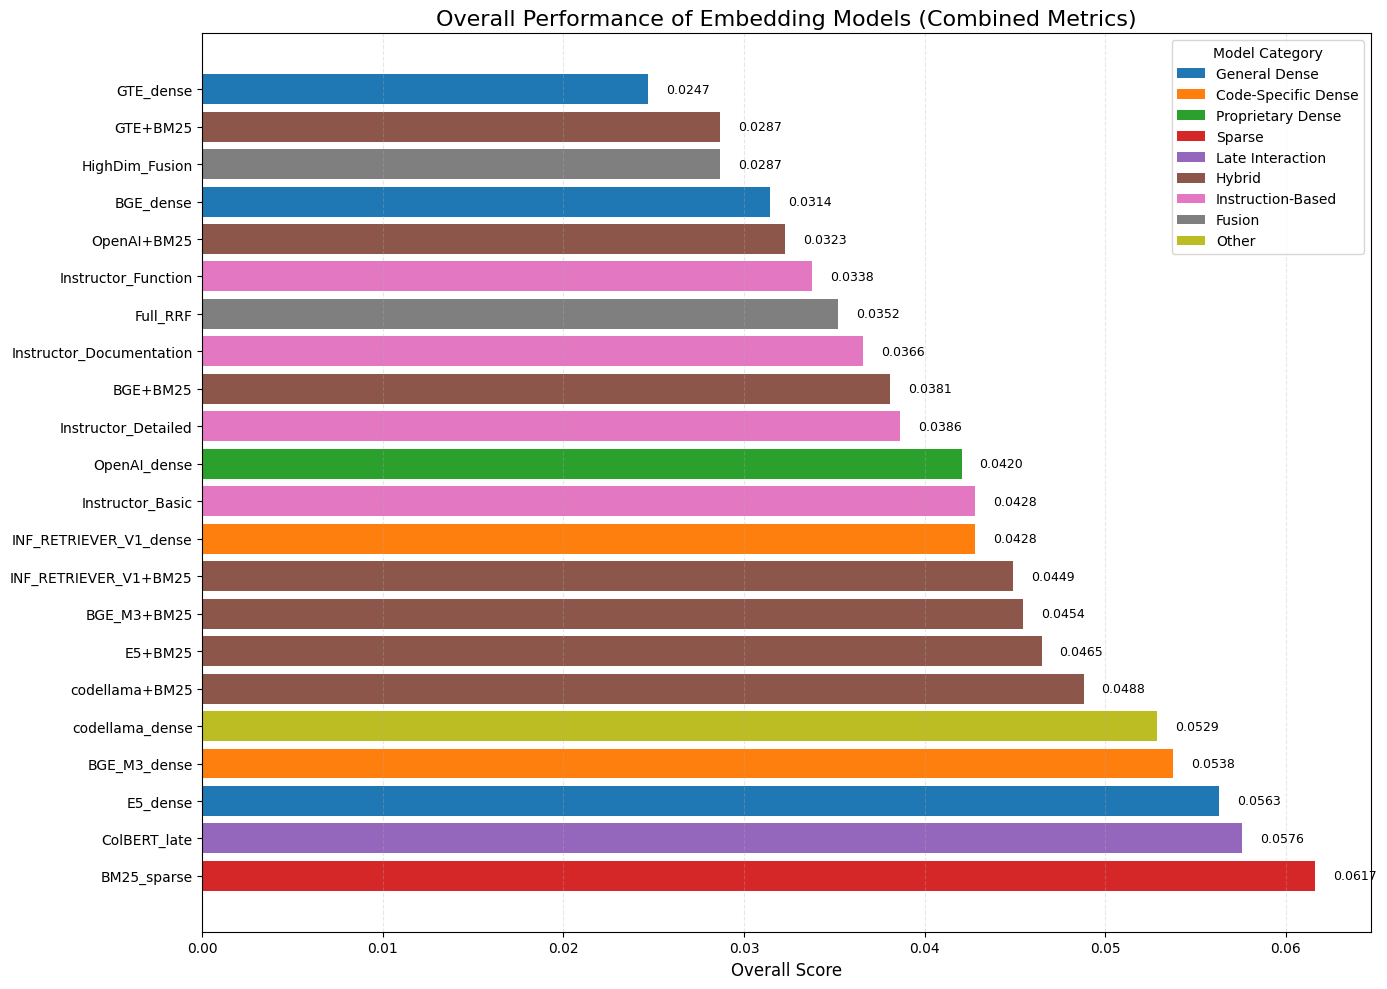

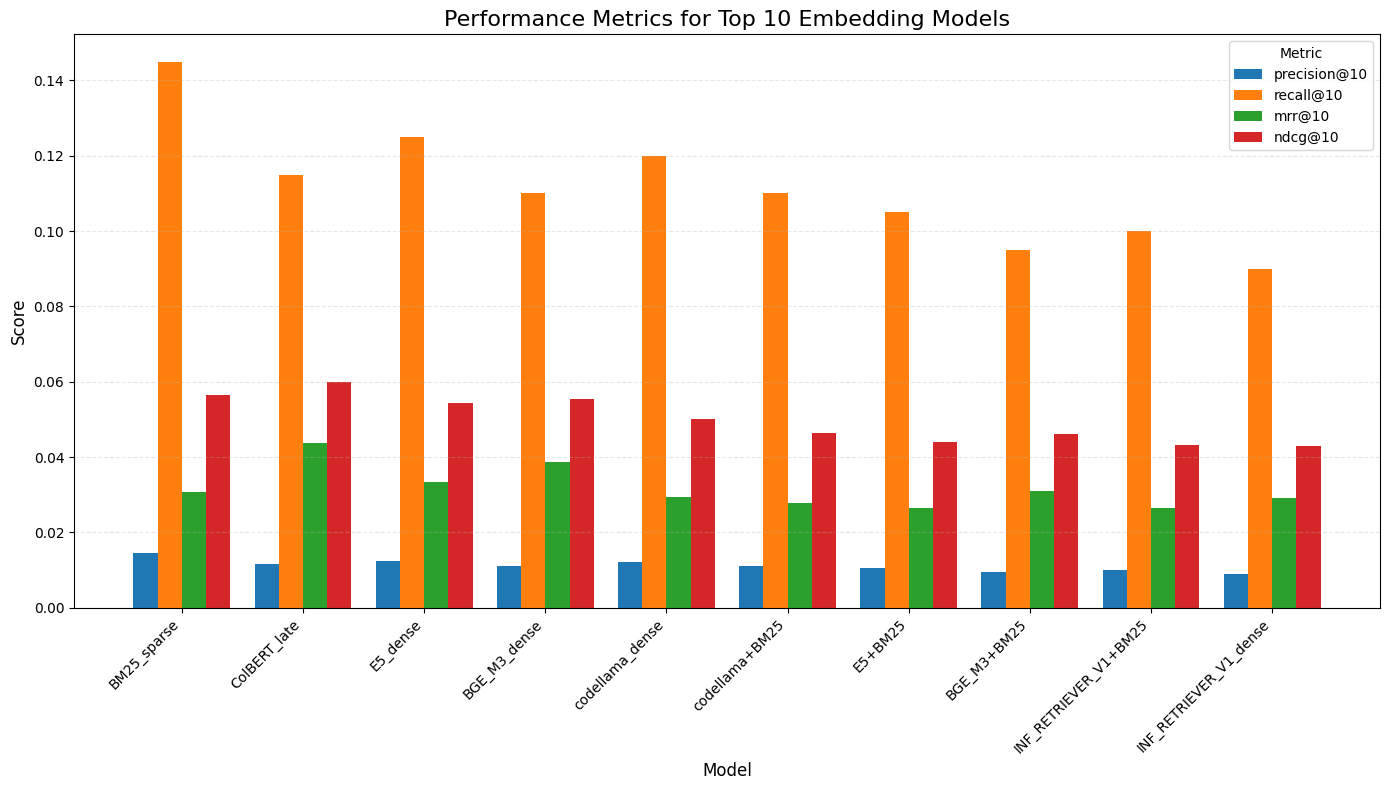

Visualizations saved as 'embedding_model_comparison.png' and 'top10_models_metrics.png'


In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a mapping from numeric indices to descriptive model names
# Adjust this mapping to match your actual models
model_mapping = {
    0: 'E5_dense',
    1: 'GTE_dense',
    2: 'BGE_dense',
    3: 'INF_RETRIEVER_V1_dense',
    4: 'BGE_M3_dense',
    5: 'OpenAI_dense',
    6: 'codellama_dense',
    7: 'BM25_sparse',
    8: 'ColBERT_late',
    9: 'E5+BM25',
    10: 'GTE+BM25',
    11: 'BGE+BM25',
    12: 'INF_RETRIEVER_V1+BM25',
    13: 'BGE_M3+BM25',
    14: 'OpenAI+BM25',
    15: 'codellama+BM25',
    16: 'HighDim_Fusion',
    17: 'Instructor_Basic',
    18: 'Instructor_Detailed',
    19: 'Instructor_Function',
    20: 'Instructor_Documentation',
    21: 'Full_RRF'
}

# Create a copy of results_df to avoid modifying the original
plot_df = results_df.copy()

# Add descriptive model names
plot_df['Model_Name'] = plot_df['model_names'].map(model_mapping)

# Calculate overall score with equal weighting
plot_df['overall_score'] = (
    plot_df['precision@10'] * 0.25 +
    plot_df['recall@10'] * 0.25 +
    plot_df['mrr@10'] * 0.25 +
    plot_df['ndcg@10'] * 0.25
)

# Sort by overall score
plot_df = plot_df.sort_values('overall_score', ascending=False)

# Categorize models
def categorize_model(name):
    if name is None:
        return 'Other'
        
    name = str(name)
    if 'E5_dense' in name or 'GTE_dense' in name or 'BGE_dense' in name:
        return 'General Dense'
    elif 'INF_RETRIEVER_V1_dense' in name or 'BGE_M3_dense' in name or 'starcoder_dense' in name:
        return 'Code-Specific Dense'
    elif 'OpenAI_dense' in name:
        return 'Proprietary Dense'
    elif 'BM25_sparse' in name:
        return 'Sparse'
    elif 'ColBERT_late' in name:
        return 'Late Interaction'
    elif '+BM25' in name:
        return 'Hybrid'
    elif 'Instructor_' in name:
        return 'Instruction-Based'
    elif 'Fusion' in name or 'RRF' in name:
        return 'Fusion'
    else:
        return 'Other'

# Apply categorization
plot_df['Category'] = plot_df['model_names'].apply(categorize_model)

# Create a DataFrame for the CSV export
csv_df = plot_df[['model_names', 'overall_score', 'precision@10', 'recall@10', 'mrr@10', 'ndcg@10', 'Category']]
csv_df.columns = ['model_names', 'Overall Score', 'Precision@10', 'Recall@10', 'MRR@10', 'NDCG@10', 'Category']
csv_df.insert(0, 'Rank', range(1, len(csv_df) + 1))

# Save to CSV
csv_df.to_csv('embedding_model_comparison.csv', index=False)
print("Results saved to 'embedding_model_comparison.csv'")

# Create visualization
plt.figure(figsize=(14, 10))

# Define category colors
category_colors = {
    'General Dense': '#1f77b4',
    'Code-Specific Dense': '#ff7f0e',
    'Proprietary Dense': '#2ca02c',
    'Sparse': '#d62728',
    'Late Interaction': '#9467bd',
    'Hybrid': '#8c564b',
    'Instruction-Based': '#e377c2',
    'Fusion': '#7f7f7f',
    'Other': '#bcbd22'
}

# Get colors based on categories
colors = [category_colors.get(cat, '#17becf') for cat in plot_df['Category']]

# Create positions for bars
y_pos = np.arange(len(plot_df))

# Create horizontal bar chart
bars = plt.barh(y_pos, plot_df['overall_score'], color=colors)

# Add value labels to bars
for i, v in enumerate(plot_df['overall_score']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# Set y-ticks to model names
plt.yticks(y_pos, plot_df['model_names'])

# Add grid and titles
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.title('Overall Performance of Embedding Models (Combined Metrics)', fontsize=16)
plt.xlabel('Overall Score', fontsize=12)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color, label=cat) 
    for cat, color in category_colors.items() 
    if cat in plot_df['Category'].unique()
]
plt.legend(handles=legend_elements, title='Model Category', loc='upper right')

plt.tight_layout()
plt.savefig('embedding_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Create additional chart showing the individual metrics for top 10 models
top10_df = plot_df.head(10).copy()

# Melt the DataFrame for easier plotting
metrics_df = pd.melt(
    top10_df, 
    id_vars=['model_names', 'Category'],
    value_vars=['precision@10', 'recall@10', 'mrr@10', 'ndcg@10'],
    var_name='Metric', 
    value_name='Score'
)

# Create a grouped bar chart
plt.figure(figsize=(14, 8))

# Get unique metrics and models
metrics = metrics_df['Metric'].unique()
models = top10_df['model_names'].values
x = np.arange(len(models))
width = 0.2

# Plot each metric as a group of bars
for i, metric in enumerate(metrics):
    metric_data = metrics_df[metrics_df['Metric'] == metric]
    plt.bar(x + (i - 1.5) * width, metric_data['Score'], width, label=metric)

# Customize the chart
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Performance Metrics for Top 10 Embedding Models', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('top10_models_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualizations saved as 'embedding_model_comparison.png' and 'top10_models_metrics.png'")

In [56]:
print("Columns in results_df:", results_df.columns)


Columns in results_df: Index(['model_names', 'precision@10', 'recall@10', 'mrr@10', 'ndcg@10'], dtype='object')


In [57]:
def check_and_fix_vector_formats(embeddings_dict, model_names):
    """
    Validates and fixes vector formats for fusion approaches.
    
    Args:
        embeddings_dict: Dictionary containing embeddings for different models
        model_names: List of model names to check
    
    Returns:
        Dictionary with fixed embeddings and a report of issues found
    """
    import numpy as np
    
    fixed_embeddings = {}
    issues_report = {}
    
    print("Checking vector format consistency...")
    
    # Check if embeddings is a nested dictionary with 'dense_embeddings'
    if 'dense_embeddings' in embeddings_dict:
        embeddings_to_check = embeddings_dict['dense_embeddings']
    else:
        embeddings_to_check = embeddings_dict
    
    for model_name in model_names:
        if model_name not in embeddings_to_check:
            issues_report[model_name] = "Missing embeddings"
            continue
            
        vectors = embeddings_to_check[model_name]
        issues = []
        
        # Check if vectors exist
        if vectors is None or len(vectors) == 0:
            issues.append("Empty vectors")
            continue
            
        # Check for None values
        none_indices = [i for i, v in enumerate(vectors) if v is None]
        if none_indices:
            issues.append(f"None values at indices: {none_indices[:5]}...")
            
        # Check dimensionality consistency
        if isinstance(vectors, list) and all(isinstance(v, (list, np.ndarray)) for v in vectors if v is not None):
            dims = [len(v) for v in vectors if v is not None and hasattr(v, '__len__')]
            if dims and len(set(dims)) > 1:
                issues.append(f"Inconsistent dimensions: {set(dims)}")
                
        # Fix dimensionality issues for specific models
        if model_name == 'INF_RETRIEVER_V1' or 'Instructor_' in model_name:
            fixed_vectors = []
            for v in vectors:
                if v is not None:
                    # Fix extra dimension issues (shape like [1, X] instead of [X])
                    if isinstance(v, np.ndarray) and len(v.shape) > 1 and v.shape[0] == 1:
                        fixed_vectors.append(v.reshape(-1))
                    else:
                        fixed_vectors.append(v)
                else:
                    fixed_vectors.append(None)
            vectors = fixed_vectors
            issues.append("Fixed dimensionality issues")
            
        # Convert all numpy arrays to lists for JSON serialization
        if isinstance(vectors, list):
            fixed_vectors = []
            for v in vectors:
                if v is not None:
                    if isinstance(v, np.ndarray):
                        fixed_vectors.append(v.tolist())
                    else:
                        fixed_vectors.append(v)
                else:
                    fixed_vectors.append(None)
            vectors = fixed_vectors
            
        fixed_embeddings[model_name] = vectors
        issues_report[model_name] = issues if issues else "No issues found"
    
    # Print report
    print("\nVector format check report:")
    for model, issues in issues_report.items():
        print(f"{model}: {issues}")
    
    return fixed_embeddings

# Apply the function correctly with your nested structure
fixed_embeddings = check_and_fix_vector_formats(
    embeddings, 
    ['E5', 'GTE', 'BGE', 'INF_RETRIEVER_V1', 'BGE_M3', 'OpenAI', 'codellama']
)

# Update your embeddings dictionary correctly
if 'dense_embeddings' in embeddings:
    for model_name, fixed_vectors in fixed_embeddings.items():
        embeddings['dense_embeddings'][model_name] = fixed_vectors
else:
    # If not nested, update directly
    embeddings.update(fixed_embeddings)

Checking vector format consistency...

Vector format check report:
E5: No issues found
GTE: No issues found
BGE: No issues found
INF_RETRIEVER_V1: ['Fixed dimensionality issues']
BGE_M3: No issues found
OpenAI: No issues found
codellama: No issues found


In [58]:
# Define categories for the models based on their names
def categorize_model(name):
    name = str(name)  # Ensure name is a string
    if 'E5_dense' in name or 'GTE_dense' in name or 'BGE_dense' in name:
        return 'General Dense'
    elif 'codellama_dense' in name or 'INF_RETRIEVER_V1_dense' in name or 'BGE_M3_dense' in name:
        return 'Code-Specific Dense'
    elif 'OpenAI_dense' in name:
        return 'Proprietary Dense'
    elif 'BM25_sparse' in name:
        return 'Sparse'
    elif 'ColBERT_late' in name:
        return 'Late Interaction'
    elif '+BM25' in name:
        return 'Hybrid'
    elif 'Instructor_' in name:
        return 'Instruction-Based'
    elif 'Fusion' in name or 'RRF' in name:
        return 'Fusion'
    else:
        return 'Other'

# Apply the categorization
results_df['Category'] = results_df['model_names'].apply(categorize_model)

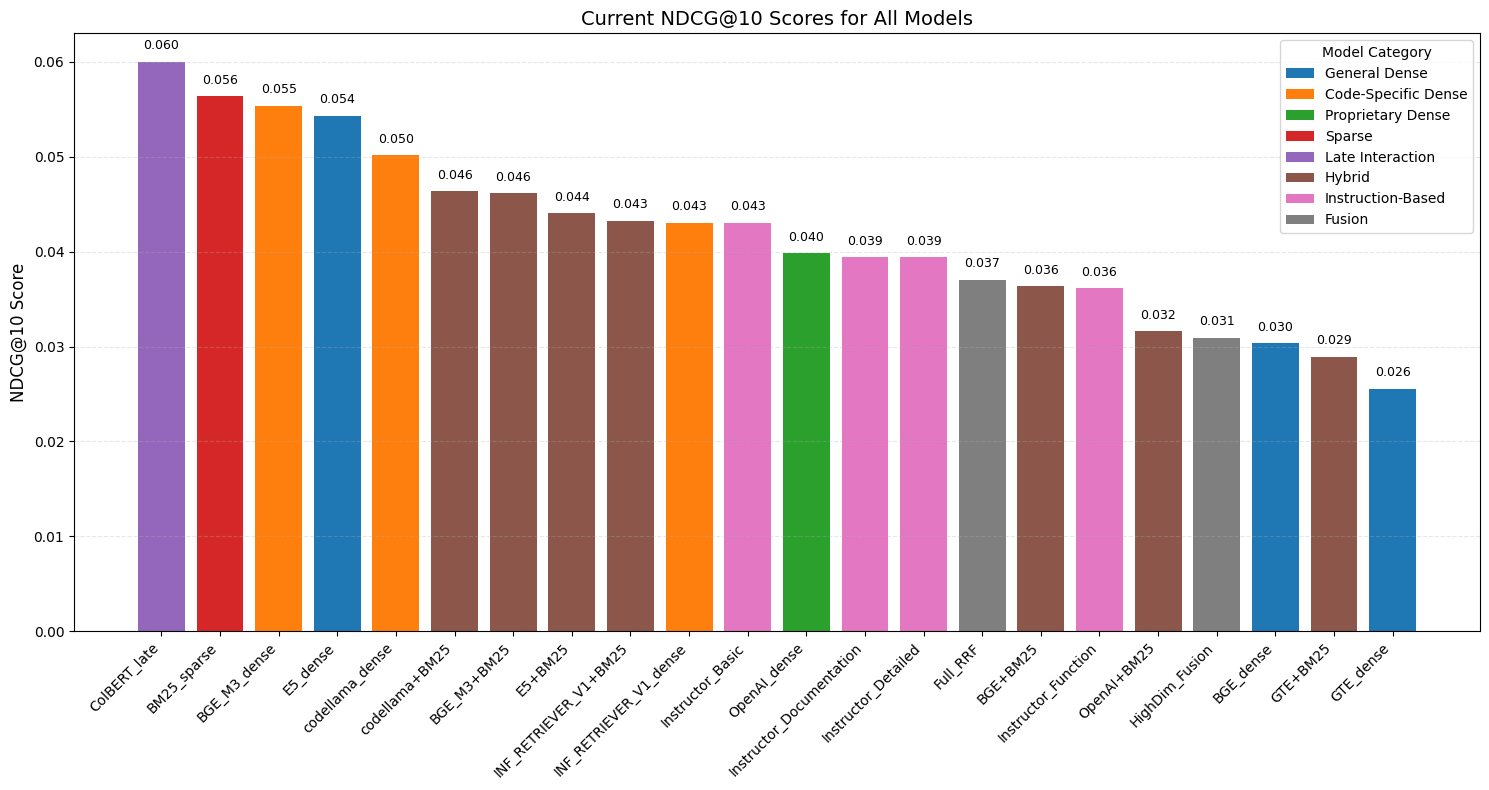

In [59]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Plot the original results
plt.figure(figsize=(15, 8))

# Sort by performance
results_df = results_df.sort_values('ndcg@10', ascending=False)

# Define colors based on category
category_colors = {
    'General Dense': '#1f77b4',
    'Code-Specific Dense': '#ff7f0e',
    'Proprietary Dense': '#2ca02c',
    'Sparse': '#d62728',
    'Late Interaction': '#9467bd',
    'Hybrid': '#8c564b',
    'Instruction-Based': '#e377c2',
    'Fusion': '#7f7f7f',
    'Other': '#17becf'
}

# Get colors for each bar
colors = [category_colors.get(cat, '#17becf') for cat in results_df['Category']]

# Create bar chart
bars = plt.bar(range(len(results_df)), results_df['ndcg@10'], color=colors)

# Add value labels
for i, v in enumerate(results_df['ndcg@10']):
    plt.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Set x-tick labels to model names
plt.xticks(range(len(results_df)), results_df['model_names'], rotation=45, ha='right')

# Add grid, titles
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.title('Current NDCG@10 Scores for All Models', fontsize=14)
plt.ylabel('NDCG@10 Score', fontsize=12)

# Add legend
legend_elements = [
    Patch(facecolor=color, label=cat) 
    for cat, color in category_colors.items() 
    if cat in results_df['Category'].unique()
]
plt.legend(handles=legend_elements, title='Model Category', loc='upper right')

plt.tight_layout()
plt.savefig('current_model_results.png', dpi=300, bbox_inches='tight')
plt.show()